In [1]:
import os
import sys
import time
import copy
import glob
import random
import joblib
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from joblib import load
from scipy import stats
from matplotlib import cm
import statsmodels.api as sm
from keras.models import Model
from scipy.stats import zscore
from collections import Counter
from scipy.stats import entropy
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import matplotlib.lines as mlines
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
from keras.models import load_model
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score
from scipy.stats import kstest, norm
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

def calculate_correlation(network_output, network_input, ground_truth, sample_idx):
    correlation_input_output = np.corrcoef(network_input[sample_idx].flatten(), network_output[sample_idx].flatten())[0, 1]
    correlation_output_truth = np.corrcoef(network_output[sample_idx].flatten(), ground_truth[sample_idx].flatten())[0, 1]

    print(f"Correlation between Input and Output for Sample {sample_idx}: {correlation_input_output}")
    print(f"Correlation between Output and Ground Truth for Sample {sample_idx}: {correlation_output_truth}")

def layer_molecule_wise_error(network_output, ground_truth):
    layer_wise_error = np.mean(np.abs(network_output - ground_truth), axis=(0, 1))  # Mean error per layer
    molecule_wise_error = np.mean(np.abs(network_output - ground_truth), axis=(0, 2))  # Mean error per molecule

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(layer_wise_error)
    plt.title('Layer-wise Mean Absolute Error')
    plt.xlabel('Layer')
    plt.ylabel('MAE')

    plt.subplot(1, 2, 2)
    plt.plot(molecule_wise_error)
    plt.title('Molecule-wise Mean Absolute Error')
    plt.xlabel('Molecule')
    plt.ylabel('MAE')

    plt.tight_layout()
    plt.show()
    
    
def plot_distributions(network_input, network_output, ground_truth, sample_idx):
    plt.figure(figsize=(12, 4))
    sns.histplot(network_input[sample_idx].flatten(), color="skyblue", label="Input", kde=True)
    sns.histplot(network_output[sample_idx].flatten(), color="red", label="Output", kde=True)
    sns.histplot(ground_truth[sample_idx].flatten(), color="green", label="Ground Truth", kde=True)
    plt.legend()
    plt.title(f'Distribution Comparison for Sample {sample_idx}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

    
def error_distribution_analysis(network_output, ground_truth):
    errors = network_output - ground_truth
    sns.histplot(errors.flatten(), kde=True, color="red")
    plt.title('Overall Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

    
    
def calculate_samplewise_mae(network_output, ground_truth):
    return np.mean(np.abs(network_output - ground_truth), axis=(1, 2))


def plot_error_vs_parameters(df, network_output, ground_truth):
    sample_mae = calculate_samplewise_mae(network_output, ground_truth)
    df['Error'] = sample_mae

    parameters = ['planet_radius', 'planet_mass', 'co_ratio', 'isothermal_T', 'metalicity']
    
    plt.figure(figsize=(15, 10))
    
    for i, param in enumerate(parameters, 1):
        plt.subplot(2, 3, i)
        sns.scatterplot(x=df[param], y=df['Error'])
        plt.xlabel(param)
        plt.ylabel('Error')
        plt.title(f'Error vs. {param}')
    
    plt.tight_layout()
    plt.show()

    
def sample_consistency_check(network_output, ground_truth):
    # Calculate MAE for each sample
    sample_mae = np.mean(np.abs(network_output - ground_truth), axis=(1, 2))

    # Plotting the distribution of MAE across samples
    plt.figure(figsize=(10, 6))
    sns.histplot(sample_mae, kde=True, bins=30)
    plt.title('Distribution of Mean Absolute Error Across Samples')
    plt.xlabel('Mean Absolute Error')
    plt.ylabel('Frequency')
    plt.show()

    # Optionally, identify samples with high error
    high_error_samples = np.where(sample_mae > np.quantile(sample_mae, 0.95))[0]
    print(f"Samples with High Error: {len (high_error_samples)}", high_error_samples)
    return high_error_samples
    
    
def multivariate_regression(df, network_output, ground_truth):
    sample_mae = calculate_samplewise_mae(network_output, ground_truth)
    df['Error'] = sample_mae

    # Independent variables
    X = df[['planet_radius', 'planet_mass', 'co_ratio', 'isothermal_T', 'metalicity']]
    X = sm.add_constant(X)  # adding a constant for the intercept

    # Dependent variable
    y = df['Error']

    model = sm.OLS(y, X).fit()
    print(model.summary())
    
    
def detect_anomalies(df, network_output, ground_truth):
    sample_mae = calculate_samplewise_mae(network_output, ground_truth)
    df['Error'] = sample_mae

    # Isolation Forest for anomaly detection
    iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
    anomalies = iso_forest.fit_predict(df[['Error']].values.reshape(-1, 1))  # Reshape for compatibility

    # Anomalies are marked as -1, normal as 1
    df['Anomaly'] = anomalies

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df['Error'], color='blue', label='Normal', alpha=0.7)
    
    # Highlight anomalies
    plt.scatter(df.index[df['Anomaly'] == -1], df['Error'][df['Anomaly'] == -1], color='red', label='Anomaly', alpha=1.0)
    plt.title('Anomalies in Model Errors')
    plt.xlabel('Sample Index')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

    # Return DataFrame with anomaly labels
    return df

def get_original_indices(position, num_molecules, num_layers):
    molecule_index = position % num_molecules
    layer_index = position // num_molecules
    return molecule_index, layer_index


def preprocessing_function(log_data, params=None):
    log_data = np.clip(log_data, a_min=-20, a_max=None)
    min_value = -20
    max_value = 0
        
    min_max_scaled_data = (log_data - min_value) / (max_value - min_value) * 2 - 1
    min_max_scaled_data = np.nan_to_num(min_max_scaled_data, 0)
    
    return min_max_scaled_data


def data_norm(name, output = False,network = False, save_idx=None):
    """Load one data example and use log transform
    Return array of size (Layers, Molecules, 1)"""
    arr = load_array_3d(name) # arr shape is (100,111) or (layers, molecules)
    if network:
        arr = arr.reshape((64,96))
        return arr
    if output :
        arr = arr[-1]
    if save_idx is not None:
        arr = arr[save_idx,:]
    arr = np.log10(arr)[:,:96]  # logarithm 
    arr = preprocessing_function(arr) 
    return arr




def load_data(data_dir, output=False,network = False, save_idx=None):
    """Load all data (Train/Test) and apply log transform
    Return it as np array of size (number_of_examples, Layers, Molecules,1)"""
    data_list = np.sort(glob.glob(f'{data_dir}/*npy'))
    array = []
    _ = [array.append(data_norm(name, output=output,network=network, save_idx=save_idx)) for name in data_list]
    array = np.array(array)
   
    return array, data_list



def create_dict(names):
    molecule_dict = {}
    for name in names:
        molecule_dict[name] = []
    return molecule_dict


def load_array_3d(filename):
    with open(filename, 'rb') as f:
        arr = np.load(f)
    return arr


def inverse_preprocessing(scaled_data):
        min_value = -20
        max_value = 0
        log_data = ((scaled_data + 1) / 2) * (max_value - min_value) + min_value
        return log_data

def gt_vs_predict_plot(ground_truth,network_output,network_input,n,ind,input_data=True):
    # Flatten the ground truth and network output for the current index
    gt_flat = ground_truth[n,ind,:].flatten()
    output_flat = network_output[n,ind,:].flatten()
    input_flat = network_input[n,ind,:].flatten()
    # Calculate residuals
    residuals = output_flat - gt_flat

    # Calculate standard deviation of the residuals
    std_residual = np.std(residuals)

    # Setup for two subplots: one for the scatter plot, one for the residuals
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

    # Scatter plot on the first subplot
    ax1.scatter(gt_flat, output_flat, alpha=0.5, label='Predicted')
    if input_data:
        ax1.scatter(gt_flat, input_flat, alpha=0.5, label = 'Input')
    min_val, max_val = gt_flat.min(), gt_flat.max()
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)  # line of equality
    ax1.set_xlabel('Ground Truth')
    ax1.set_ylabel('Predicted')
    ax1.set_title(f'Predicted vs. Actual Values {molecules[ind]}')
    ax1.legend()
    # Residuals plot on the second subplot
    ax2.scatter(gt_flat, residuals, alpha=0.5, color='red')
    ax2.hlines(0, min_val, max_val, colors='k', linestyles='-', lw=1.5, label='Perfect prediction')  # zero line for residuals

    # Adding sigma lines to the residuals plot
    colors = ['red','blue','cyan','gold']
    for sigma in [1, 2, 3]:
        ax2.hlines(sigma * std_residual, min_val, max_val, colors='blue', linestyles='--',
                   color = colors[sigma],lw=2, label=f'{sigma}σ')
        ax2.hlines(-sigma * std_residual, min_val, max_val, colors='blue', linestyles='--',
                   color = colors[sigma],lw=2)

    ax2.set_xlabel('Ground Truth')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'Residuals Plot {molecules[ind]}')

    # Adding legend to the residuals plot
    ax2.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

def molecule_plot(network_output,network_input, ground_truth,n, chosen_molecules, save=False):
    fig, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

    # Main plot
    ax = axs[0]
    for i, mol in enumerate(chosen_molecules):
        color = colors[i % len(colors)] 
        ax.plot(inverse_preprocessing(network_output[n, molecules.index(mol), :]), np.arange(0,64), '--', lw=3, label=mol, color=color)
        ax.plot(inverse_preprocessing(network_input[n, molecules.index(mol), :]), np.arange(0,64), '-.', lw=3, color=color)
        ax.plot(inverse_preprocessing(ground_truth[n, molecules.index(mol), :]), np.arange(0,64), '-', lw=1, color=color)



    co,m,t= configuration.loc[n][['co_ratio','metalicity','isothermal_T']]
    # Adjust legend position
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(alpha=0.3)
    ax.set_title(f'Atmosphere {n}, C/O ratio {round(co, 3)}, Temperature {round(t,0)}')
    ax.set_xlabel('Normalised Volume Mixing Ratio')
    ax.set_ylabel('Height Layer')

    # Create custom lines for the additional legend
    line_output = mlines.Line2D([], [], color='black', linestyle='--', linewidth=3, label='Network Output')
    line_input = mlines.Line2D([], [], color='black', linestyle='-.', linewidth=3, label='Network Input')
    line_truth = mlines.Line2D([], [], color='black', linestyle='-', linewidth=1, label='Ground Truth')

    # Add the additional legend


    # Residual plot
    ax_res = axs[1]
    for i, mol in enumerate(chosen_molecules):
        color = colors[i % len(colors)]
        residual = inverse_preprocessing(ground_truth[n, molecules.index(mol), :]) - inverse_preprocessing(network_output[n, molecules.index(mol), :])
        ax_res.plot(residual, np.arange(0,64),'.', label=mol, color=color,)
    ax_res.legend(handles=[line_output, line_input, line_truth], loc='lower left', bbox_to_anchor=(1, 0))
    ax_res.set_xlabel('Residual (Ground Truth - Network Output)')
    ax_res.set_ylabel('Height Layer')
    ax_res.grid(alpha=0.3)
    plt.tight_layout()
    if save:
        plt.savefig(f'Atmosphere_{n}_co_ratio_{round(co, 3)}_Temperature_{round(t,0)}.png')
    plt.show()
    


def calculate_correlations(df, network_output, ground_truth):
    sample_mae = calculate_samplewise_mae(network_output, ground_truth)
    df['Error'] = sample_mae

    parameters = ['planet_radius', 'planet_mass', 'co_ratio', 'isothermal_T', 'metalicity']
    
    for param in parameters:
        pearson_corr, _ = pearsonr(df[param], df['Error'])
        spearman_corr, _ = spearmanr(df[param], df['Error'])
        
        print(f"{param} - Pearson correlation with error: {pearson_corr:.3f}")
        print(f"{param} - Spearman correlation with error: {spearman_corr:.3f}")



def visualize_sample_analysis(network_input, network_output, ground_truth, sample_idx):
    error_sample = network_output[sample_idx] - ground_truth[sample_idx]

    # Statistical summary of errors
    error_stats = {
        'Mean Error': np.mean(error_sample),
        'Median Error': np.median(error_sample),
        'Standard Deviation of Error': np.std(error_sample)
    }

    # Visualizing the sample
    plt.figure(figsize=(10, 10))  # Adjust the figure size as needed

    plt.subplot(2, 2, 1)
    plt.imshow(network_input[sample_idx].T, cmap='hot')
    plt.title('Input Sample')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.imshow(network_output[sample_idx].T, cmap='hot')
    plt.title('Network Output')
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.imshow(ground_truth[sample_idx].T, cmap='hot')
    plt.title('Ground Truth')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(error_sample.T, cmap='hot')
    plt.title('Error (Output - Ground Truth)')
    plt.colorbar()
    plt.gca().invert_yaxis()

    plt.suptitle(f'Detailed Error Analysis for Sample Index: {sample_idx}')
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()

    # Printing error statistics
    print(f"Error Statistics for Sample {sample_idx}:")
    for key, value in error_stats.items():
        print(f"{key}: {value}")

def logVMR_vs_pressure(network_output, network_input, ground_truth, n, chosen_molecules, pascals_values,
                  name=None, save=False):
    if n not in index_atmosphere_dict:
        index_atmosphere_dict[n]=n
    co,m,t= configuration.loc[n][['co_ratio','metalicity','isothermal_T']]
    bars_values = convert_pascals_to_bars(pascals_values)
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    # Main plot
    ax = axs[0]
    for i, mol in enumerate(chosen_molecules):
        color = colors[i % len(colors)]
        ax.plot(inverse_preprocessing(network_output[n, molecules.index(mol), :]), bars_values, '--',
                lw=3, label=mol, color=color)
        ax.plot(inverse_preprocessing(ground_truth[n, molecules.index(mol), :]), bars_values, '-',
                lw=1, color=color)

    ax.set_yscale('log')
    ax.invert_yaxis()

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
   
    ax.grid(alpha=0.3)
    ax.set_title(f'Model {name}, Atmosphere {index_atmosphere_dict[n]}')
    
    ax.set_xlabel('Log (Volume Mixing Ratio)')
    ax.set_ylabel('Pressure (bars)')

    # Define custom lines for the legend here
    line_output = mlines.Line2D([], [], color='black', linestyle='--', linewidth=3, label='Network Output')
    line_truth = mlines.Line2D([], [], color='black', linestyle='-', linewidth=1, label='Ground Truth')

    # Residual plot
    ax_res = axs[1]
    for i, mol in enumerate(chosen_molecules):
        color = colors[i % len(colors)]
        residual = inverse_preprocessing(ground_truth[n, molecules.index(mol), :]) - inverse_preprocessing(network_output[n, molecules.index(mol), :])
        ax_res.plot(residual, bars_values, '.', label=mol, color=color)
    ax_res.legend(handles=[line_output, line_truth],loc='upper center', bbox_to_anchor=(0.5, 1.4),
                  fancybox=True, shadow=True, ncol=2)
    ax_res.set_xlabel('Residual (Ground Truth - Network Output)')
    ax_res.set_ylabel('Pressure (bars)')
    ax_res.grid(alpha=0.3)
    ax_res.invert_yaxis()
    ax_res.set_yscale('log')
    plt.tight_layout()
    if save:
        plt.savefig(f'Atmosphere_{n}_{name}_V2.png')
    plt.show()
    
def convert_pascals_to_bars(pascals):
        """Convert a list of values from Pascals to Bars."""
        return [pascal * 1e-5 for pascal in pascals]

In [9]:
data_example = pd.read_csv(glob.glob(...)[0])
pressure = np.array(data_example['Pressure'].to_list())[:64]
data_example = data_example.drop(columns=['Altitude_m','Pressure'])

molecules = data_example.columns.to_list()
molecule_dict = create_dict(molecules)


save_molecules = np.array([ 34,  36,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  90,  91,
        94,  96,  97, 100, 101, 102, 104, 105, 106, 108, 109, 110])

molecule_len = len(save_molecules)
molecules = list(np.array(molecules)[save_molecules])
network_output, data_list= load_data(..., save_idx=save_molecules, network=True)
network_input, _= load_data(..., save_idx=save_molecules)

file_names = [path.split('/')[-1].split('.')[0] for path in data_list]


data_list_X = np.sort(glob.glob(...))
file_names = [path.split('/')[-1] for path in data_list_X]

configuration = pd.read_csv(...)[:5148]
co_ratio = np.array(configuration['co_ratio'].to_list())
planet_mass = np.array(configuration['planet_mass'].to_list())
planet_radius = np.array(configuration['planet_radius'].to_list())
temp = np.array(configuration['isothermal_T'].to_list())
metallicity = np.array(configuration['metalicity'].to_list())


ground_truth, data_list_gt= load_data(..., save_idx=save_molecules, output=True)
file_names_gt = [path.split('/')[-1].split('.')[0] for path in data_list_gt]

In [5]:
data_example = pd.read_csv(glob.glob('/Users/sponka/Desktop/taurex/taurex/data/mix_profiles/*csv')[0])
pressure_chexanet = np.array(data_example['Pressure'].to_list())[:96]
pressure = np.array(data_example['Pressure'].to_list())[:96]
pressure_full = np.array(data_example['Pressure'].to_list())
data_example = data_example.drop(columns=['Altitude_m','Pressure'])

molecules = data_example.columns.to_list()
molecule_dict = create_dict(molecules)

save_molecules = np.array([ 34,  36,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  90,  91,
        94,  96,  97, 100, 101, 102, 104, 105, 106, 108, 109, 110])


path = '/Users/sponka/Desktop/taurex/taurex/U-net/evaluation/test_data2/'
molecule_len = len(save_molecules)
molecules = list(np.array(molecules)[save_molecules])
network_output, data_list= load_data(f'{path}network_output_chexanet_test5_3008/', save_idx=save_molecules, network=True)

file_names = [path.split('/')[-1].split('.')[0] for path in data_list]
configuration = pd.read_csv(f'{path}save_configuration_version2.csv')[:5148]
configuration = configuration[configuration['System_ID'].isin(file_names)]
configuration = configuration.sort_values(by='System_ID', key=lambda x:
                                                    x.map({name: i for i, name in enumerate(file_names)}))
configuration = configuration.reset_index(drop=True)
network_input, _= load_data(f'{path}input/', save_idx=save_molecules)

file_names = [path.split('/')[-1].split('.')[0] for path in data_list]


data_list_X = np.sort(glob.glob('/Users/sponka/Desktop/taurex/taurex/data/mix_profiles/*npy'))
file_names = [path.split('/')[-1] for path in data_list_X]

co_ratio = np.array(configuration['co_ratio'].to_list())
planet_mass = np.array(configuration['planet_mass'].to_list())
planet_radius = np.array(configuration['planet_radius'].to_list())
temp = np.array(configuration['isothermal_T'].to_list())
metallicity = np.array(configuration['metalicity'].to_list())

ground_truth, data_list_gt= load_data(f'{path}output', save_idx=save_molecules, output=True)
file_names_gt = [path.split('/')[-1].split('.')[0] for path in data_list_gt]

In [3]:
# Atmospheres identification
index_atmosphere_dict = {
    3423: 'A1',
    32: 'A2',
    3102: 'A3',
    1291: 'A4',
    2730: 'A5',
    3037: 'A6'}

In [7]:
mae_per_atmosphere = np.mean(np.abs(ground_truth - network_output), axis=(1, 2))

epsilon = 1e-10
mape_per_atmosphere = np.mean(np.abs((network_output - ground_truth) / (ground_truth + epsilon)), axis=(1, 2)) * 100
percentile_99 = np.percentile(mape_per_atmosphere, 99.9)
mape_per_atmosphere = np.minimum(mape_per_atmosphere, percentile_99)
# Calculate highest, lowest, and average MAE and MAPE
highest_mae = round(np.max(mae_per_atmosphere), 4)
lowest_mae = round(np.min(mae_per_atmosphere), 4)
average_mae = round(np.mean(mae_per_atmosphere), 4)

highest_mape = np.max(mape_per_atmosphere)
lowest_mape = np.min(mape_per_atmosphere)
average_mape = np.mean(mape_per_atmosphere)



# Find indices of highest, lowest, and closest to average MAE and MAPE
index_of_highest_mae = np.argmax(mae_per_atmosphere)
index_of_lowest_mae = np.argmin(mae_per_atmosphere)
index_closest_to_average_mae = np.abs(mae_per_atmosphere - average_mae).argmin()

index_of_highest_mape = np.argmax(mape_per_atmosphere)
index_of_lowest_mape = np.argmin(mape_per_atmosphere)
index_closest_to_average_mape = np.abs(mape_per_atmosphere - average_mape).argmin()

print(f"MAE - Highest: {highest_mae}, Index: {index_of_highest_mae}")
print(f"MAE - Lowest: {lowest_mae}, Index: {index_of_lowest_mae}")
print(f"MAE - Average: {average_mae}, Index Closest to Average: {index_closest_to_average_mae}")

print(f"MAPE - Highest: {highest_mape}, Index: {index_of_highest_mape}")
print(f"MAPE - Lowest: {lowest_mape}, Index: {index_of_lowest_mape}")
print(f"MAPE - Average: {average_mape}, Index Closest to Average: {index_closest_to_average_mape}")

MAE - Highest: 0.0356, Index: 3423
MAE - Lowest: 0.0006, Index: 2730
MAE - Average: 0.0021, Index Closest to Average: 3102
MAPE - Highest: 206.90025511811828, Index: 2584
MAPE - Lowest: 0.5738482347715352, Index: 3067
MAPE - Average: 3.6561138068181975, Index Closest to Average: 3089


In [8]:
network_input_2d = network_input.reshape(network_input.shape[0], -1)
network_output_2d = network_output.reshape(network_output.shape[0], -1)
ground_truth_2d = ground_truth.reshape(ground_truth.shape[0], -1)
variance_per_sample = np.var(network_output, axis=(1, 2), ddof=1)
variance_per_sample_gt = np.var(ground_truth, axis=(1, 2), ddof=1)

# 1. Accuracy of Predictions
mse_net = mean_squared_error(ground_truth_2d, network_output_2d)
mae_net = mean_absolute_error(ground_truth_2d, network_output_2d)
std_net=np.std(ground_truth_2d - network_output_2d)
median_net=np.median(ground_truth_2d - network_output_2d)
print('\nError for output/ground truth')
print(f'Mean Squared Error: {mse_net}')
print(f'Mean Absolute Error: {mae_net}')
print(f'STD: {std_net}')
print(f'Median: {median_net}')
print("Mean Variance:", np.mean(variance_per_sample))

print('\nError for input/ground truth')
mse = mean_squared_error(ground_truth_2d, network_input_2d)
mae = mean_absolute_error(ground_truth_2d, network_input_2d)
std=np.std(ground_truth_2d - network_input_2d)
median=np.median(ground_truth_2d - network_input_2d)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'STD: {std}')
print(f'Median: {median}')
print("Mean Variance:", np.mean(variance_per_sample_gt))



Error for output/ground truth
Mean Squared Error: 2.1648155184896905e-05
Mean Absolute Error: 0.002110478636771712
STD: 0.004652753669152496
Median: 3.5942779651354506e-05
Mean Variance: 0.26235646

Error for input/ground truth
Mean Squared Error: 0.06209298155267589
Mean Absolute Error: 0.15574506821325915
STD: 0.21188222440071713
Median: 0.07839902801338117
Mean Variance: 0.26233566539183506


In [9]:
num_samples_above_10_percent = np.sum(mape_per_atmosphere > 10)
p_10 = round(100*num_samples_above_10_percent/len(mape_per_atmosphere),2)
print(f"Number of samples with MAPE > 10%: {num_samples_above_10_percent}")
print(f"Percentage of samples with MAPE > 10%: {p_10}%")
indices_above_10_percent = np.where(mape_per_atmosphere > 10)[0]

Number of samples with MAPE > 10%: 223
Percentage of samples with MAPE > 10%: 4.33%


In [10]:
num_samples_above_50_percent = np.sum(mape_per_atmosphere > 50)
p_50 = round(100*num_samples_above_50_percent/len(mape_per_atmosphere),2)
print(f"Number of samples with MAPE > 50%: {num_samples_above_50_percent}")
print(f"Percentage of samples with MAPE > 50%: {p_50}%")


Number of samples with MAPE > 50%: 25
Percentage of samples with MAPE > 50%: 0.49%


In [11]:
l_error = index_of_lowest_mae
h_error = index_of_highest_mae
a_error = index_closest_to_average_mae

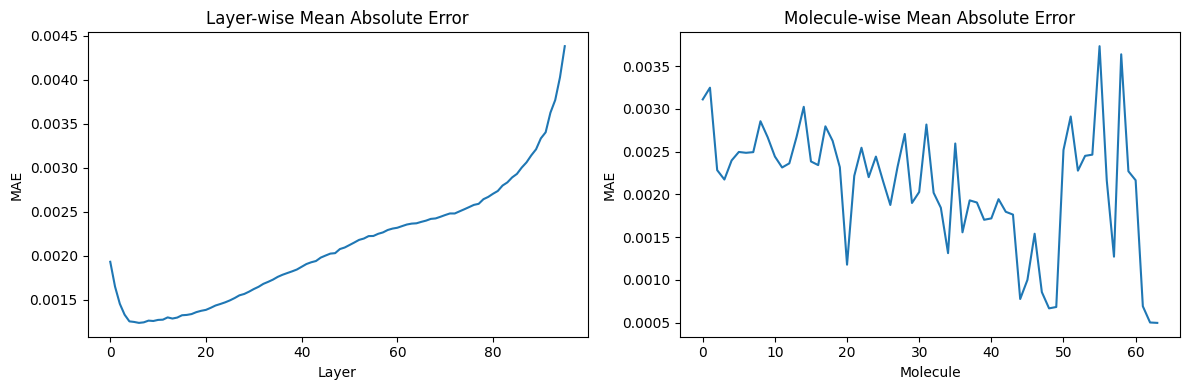

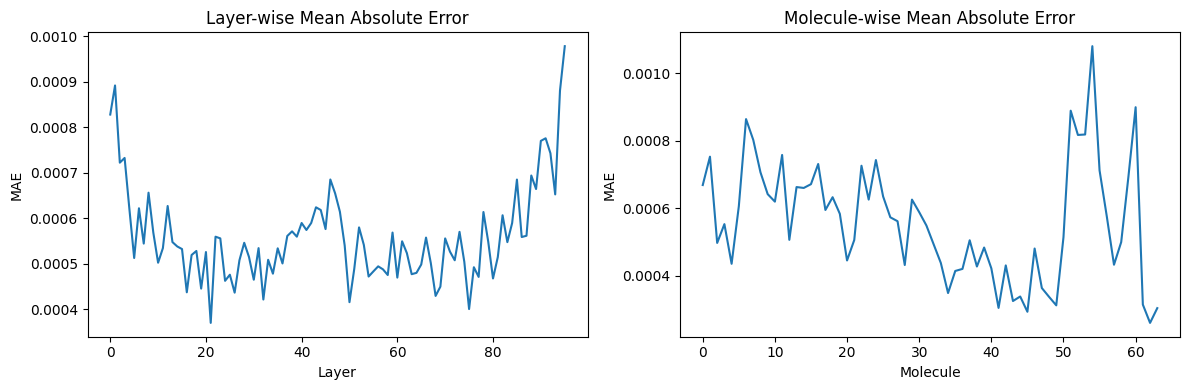

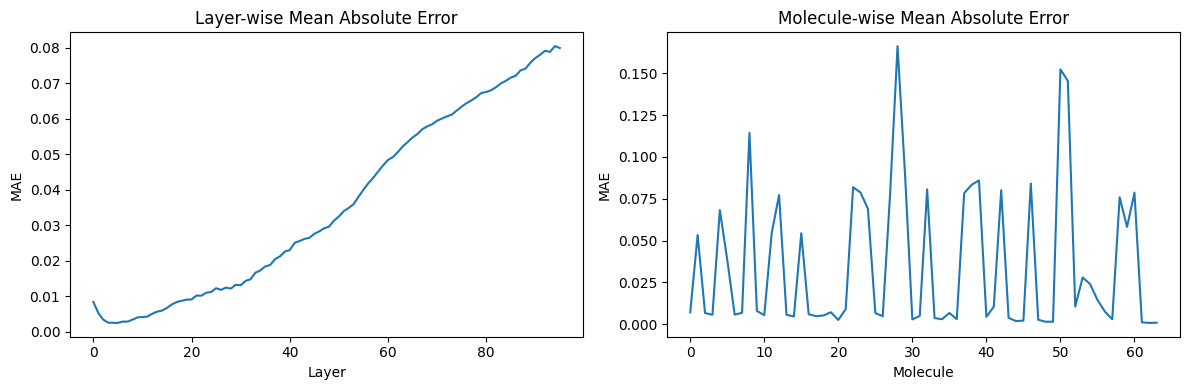

In [12]:
layer_molecule_wise_error(network_output, ground_truth)
layer_molecule_wise_error(network_output[[l_error]], ground_truth[[l_error]])
layer_molecule_wise_error(network_output[[h_error]], ground_truth[[h_error]])


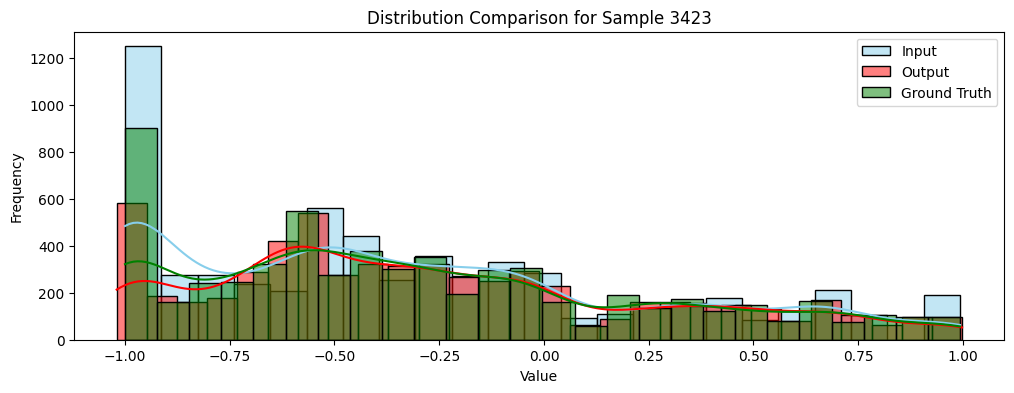

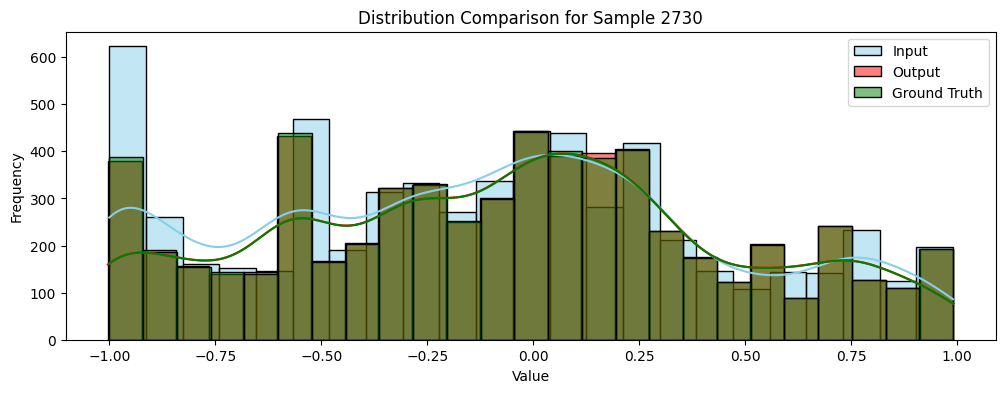

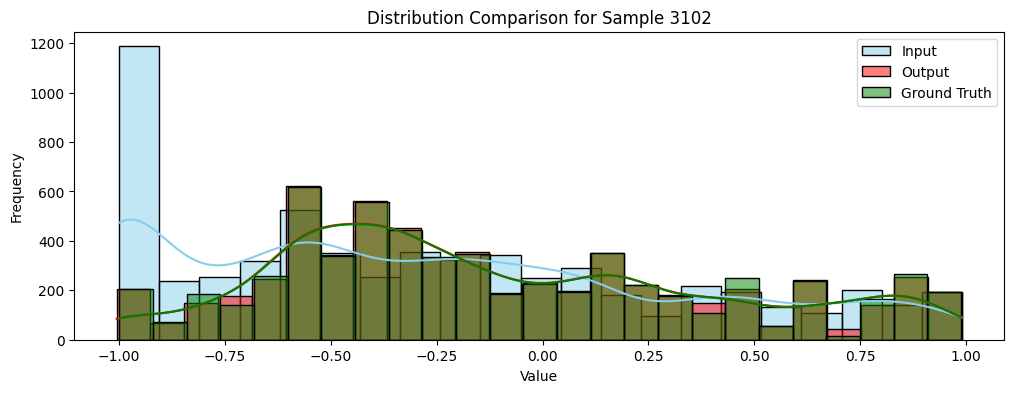

In [13]:
#2489, 2006, 441
plot_distributions(network_input, network_output, ground_truth, sample_idx=h_error)
plot_distributions(network_input, network_output, ground_truth, sample_idx=l_error)
plot_distributions(network_input, network_output, ground_truth, sample_idx=a_error)

Number of outliers: 580


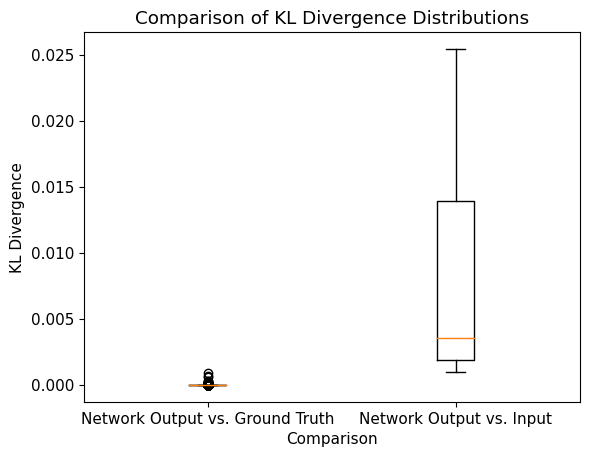

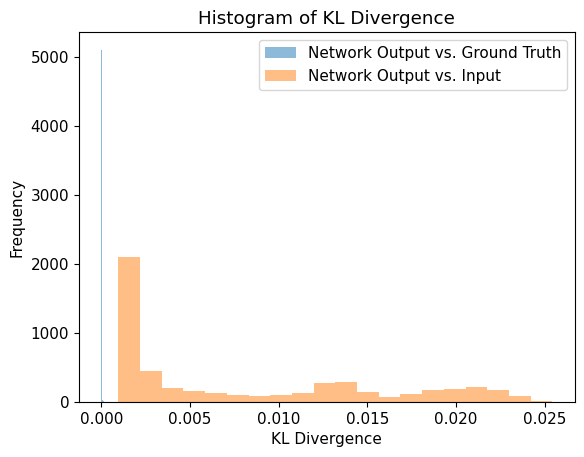

In [14]:
kl_div_gt_to_network = []  # List to store KL divergence between ground truth and network output
kl_div_gt_to_input = []    # List to store KL divergence between ground truth and input

epsilon = 2  # Small constant to prevent zero probabilities

for i in range(5148):
    gt = ground_truth[i].flatten() + epsilon
    no = network_output[i].flatten() + epsilon
    ni = network_input[i].flatten() + epsilon  # Corrected variable name
    
    # Normalize the distributions
    gt_normalized = gt / np.sum(gt)
    no_normalized = no / np.sum(no)
    ni_normalized = ni / np.sum(ni)
    
    # Calculate KL divergence
    kl_divergence_gt_to_network = entropy(no_normalized, gt_normalized)
    kl_divergence_gt_to_input = entropy(no_normalized, ni_normalized)
    
    kl_div_gt_to_network.append(kl_divergence_gt_to_network)
    kl_div_gt_to_input.append(kl_divergence_gt_to_input)



matplotlib.rcParams.update({'font.size': 11})
box_plot = plt.boxplot([kl_div_gt_to_network, kl_div_gt_to_input], labels=['Network Output vs. Ground Truth', 'Network Output vs. Input'])
plt.xlabel('Comparison')
plt.ylabel('KL Divergence')
plt.title('Comparison of KL Divergence Distributions')

# Get the outlier data and indices
outlier_data = [item.get_ydata() for item in box_plot['fliers']]
outlier_indices = []

# Iterate through the outlier data to find indices
for i, data in enumerate(outlier_data):
    if len(data) > 0:
        # Find the indices of data points that match the outlier values
        indices = [j for j, value in enumerate(kl_div_gt_to_network) if value in data]
        outlier_indices.append(indices)
outlier_indices = outlier_indices[0]
# Print the indices of outliers
print("Number of outliers:", len(outlier_indices))

# Show the box plot
plt.show()

# Visualization using histograms
plt.hist(kl_div_gt_to_network, alpha=0.5, label='Network Output vs. Ground Truth', bins=20)
plt.hist(kl_div_gt_to_input, alpha=0.5, label='Network Output vs. Input', bins=20)
plt.xlabel('KL Divergence')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of KL Divergence')
plt.show()


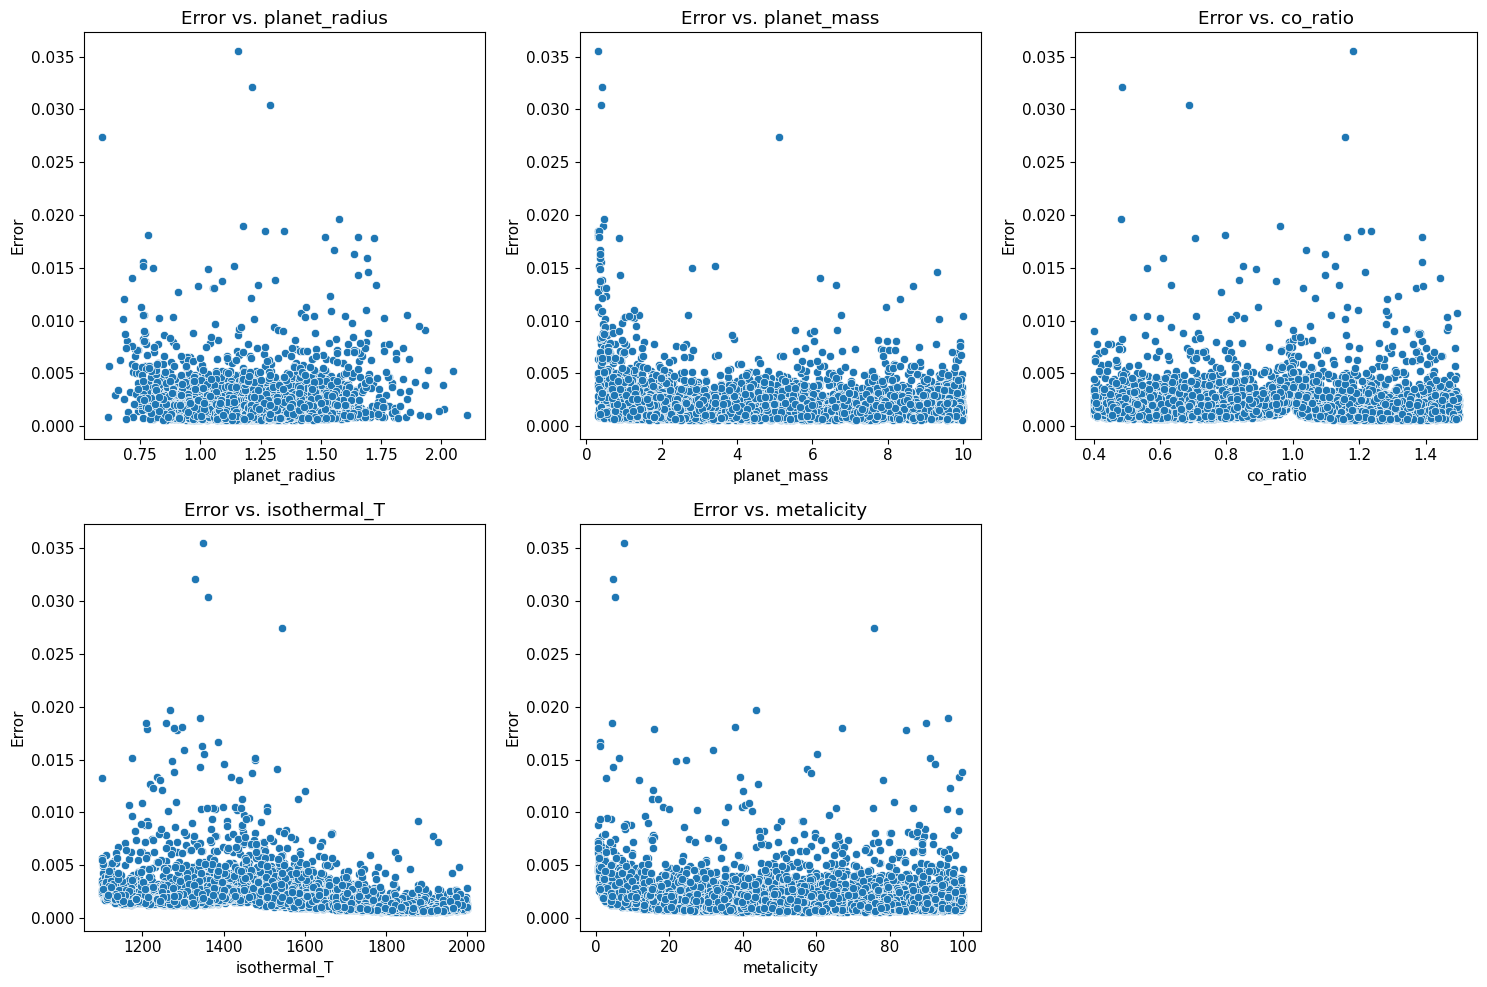

In [15]:
plot_error_vs_parameters(configuration, network_output, ground_truth)

In [16]:
calculate_correlations(configuration, network_output, ground_truth)

planet_radius - Pearson correlation with error: 0.044
planet_radius - Spearman correlation with error: -0.030
planet_mass - Pearson correlation with error: -0.151
planet_mass - Spearman correlation with error: -0.060
co_ratio - Pearson correlation with error: -0.020
co_ratio - Spearman correlation with error: -0.097
isothermal_T - Pearson correlation with error: -0.331
isothermal_T - Spearman correlation with error: -0.609
metalicity - Pearson correlation with error: -0.124
metalicity - Spearman correlation with error: -0.181


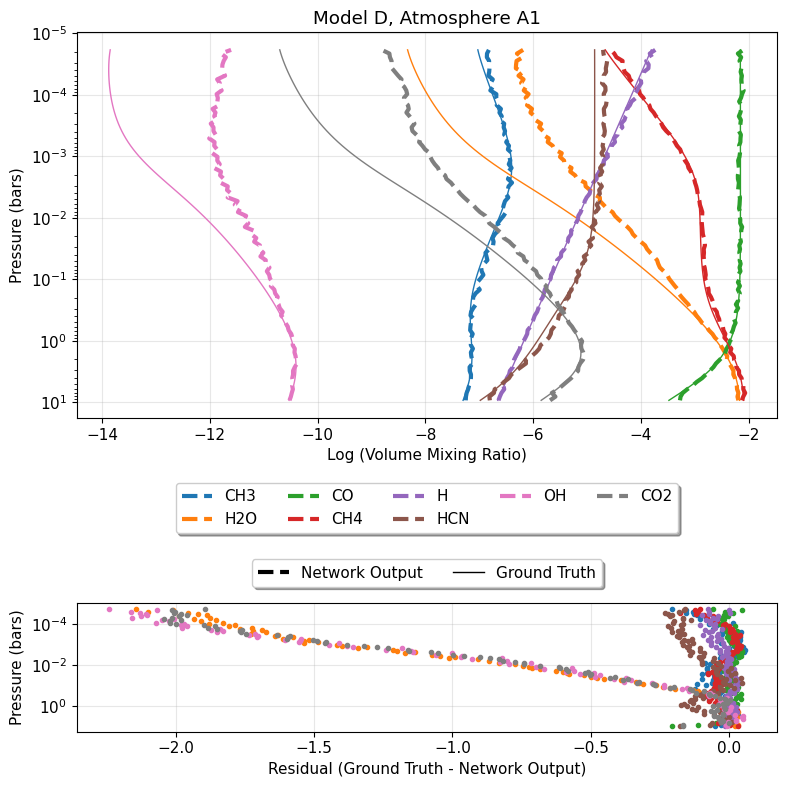

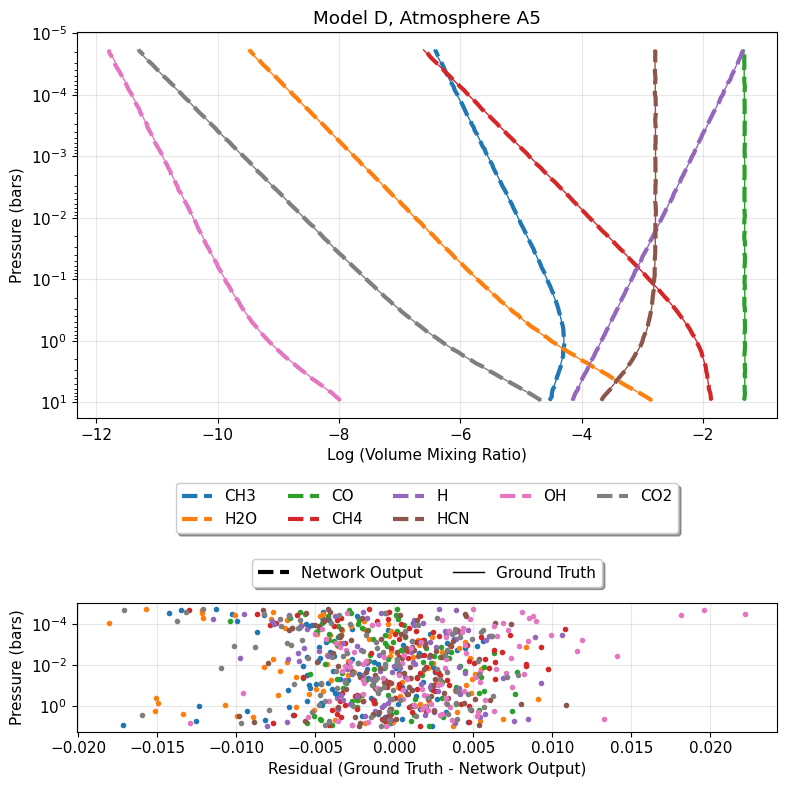

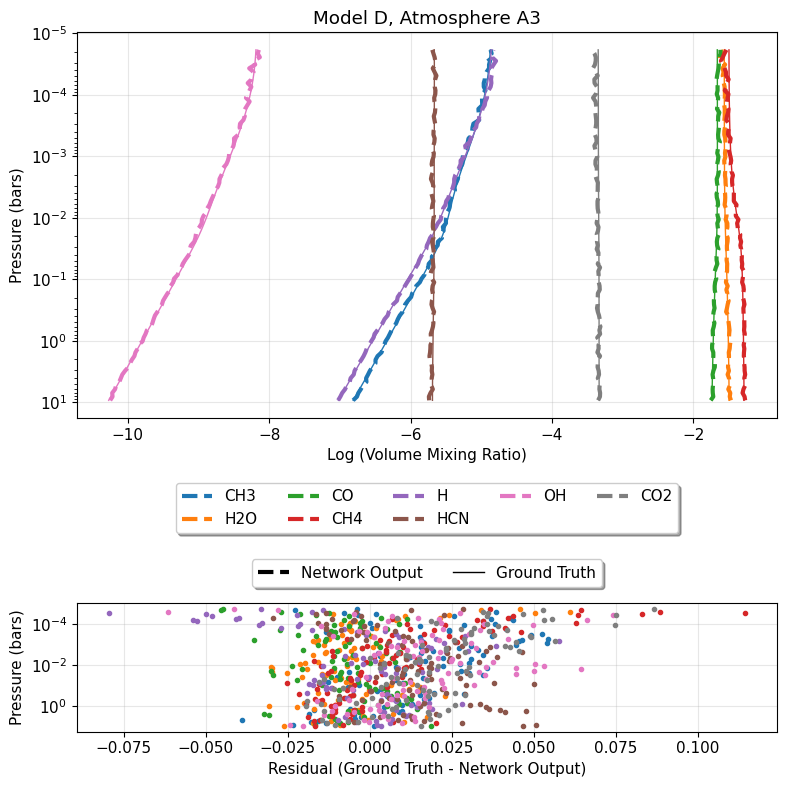

In [17]:
chosen_molecules = ['CH3', 'H2O', 'CO','CH4','H','HCN','OH','CO2']
logVMR_vs_pressure(network_output, network_input, ground_truth, h_error, 
                   chosen_molecules, pressure, name='D', save=False)
logVMR_vs_pressure(network_output, network_input, ground_truth, l_error, 
                   chosen_molecules, pressure, name='D', save=False)
logVMR_vs_pressure(network_output, network_input, ground_truth, a_error, 
                   chosen_molecules, pressure, name='D', save=False)

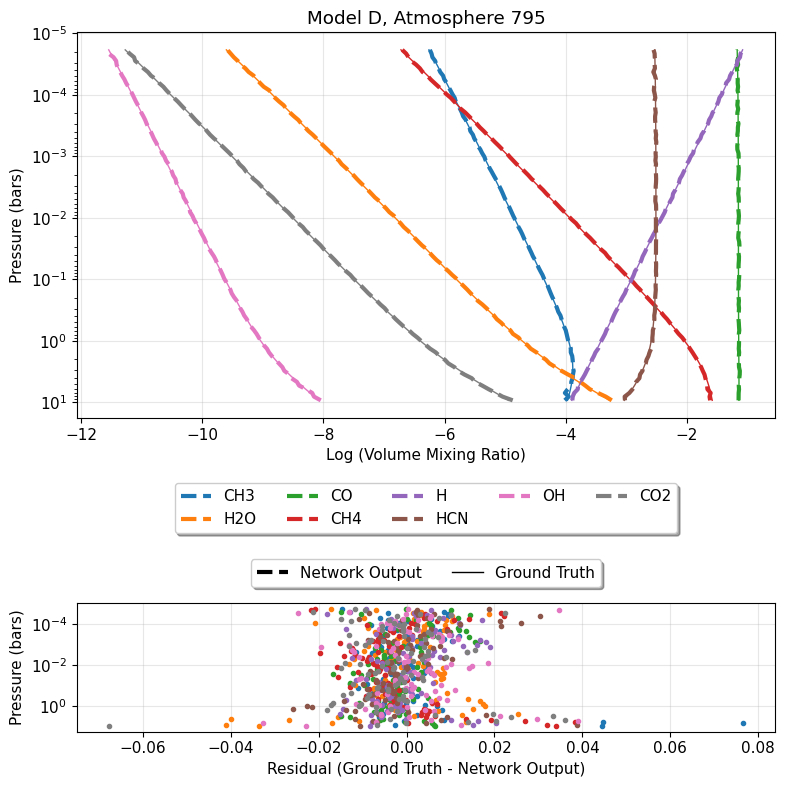

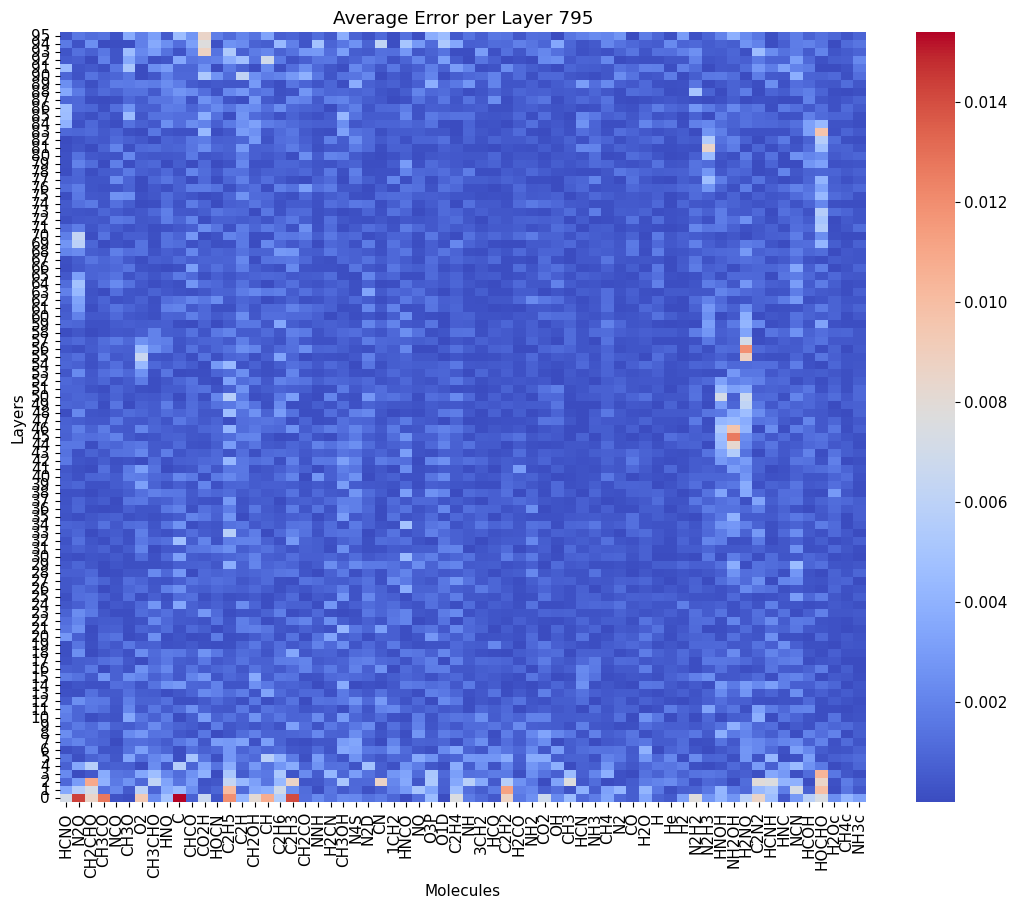

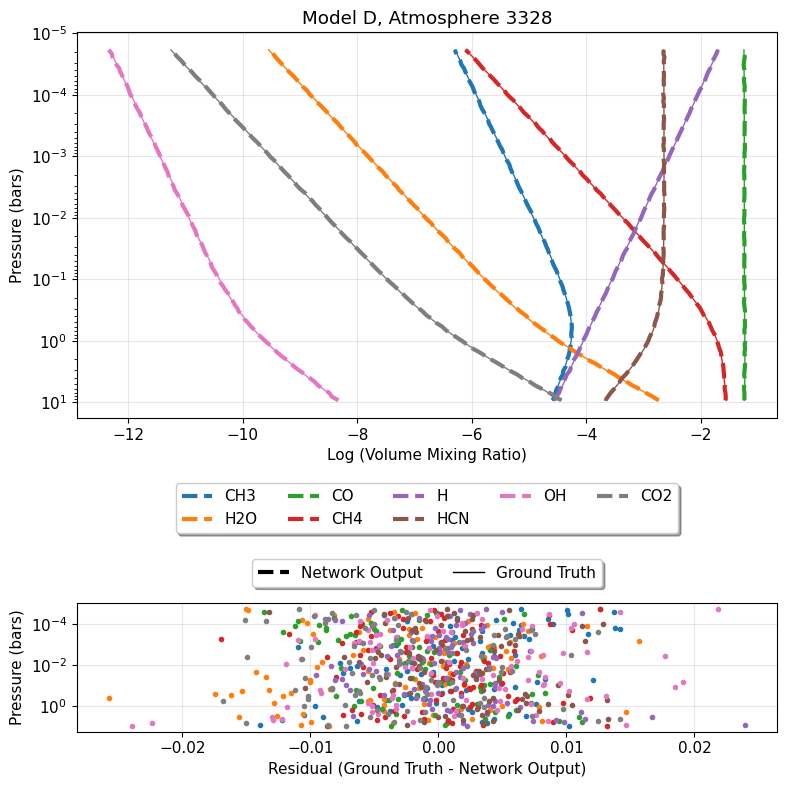

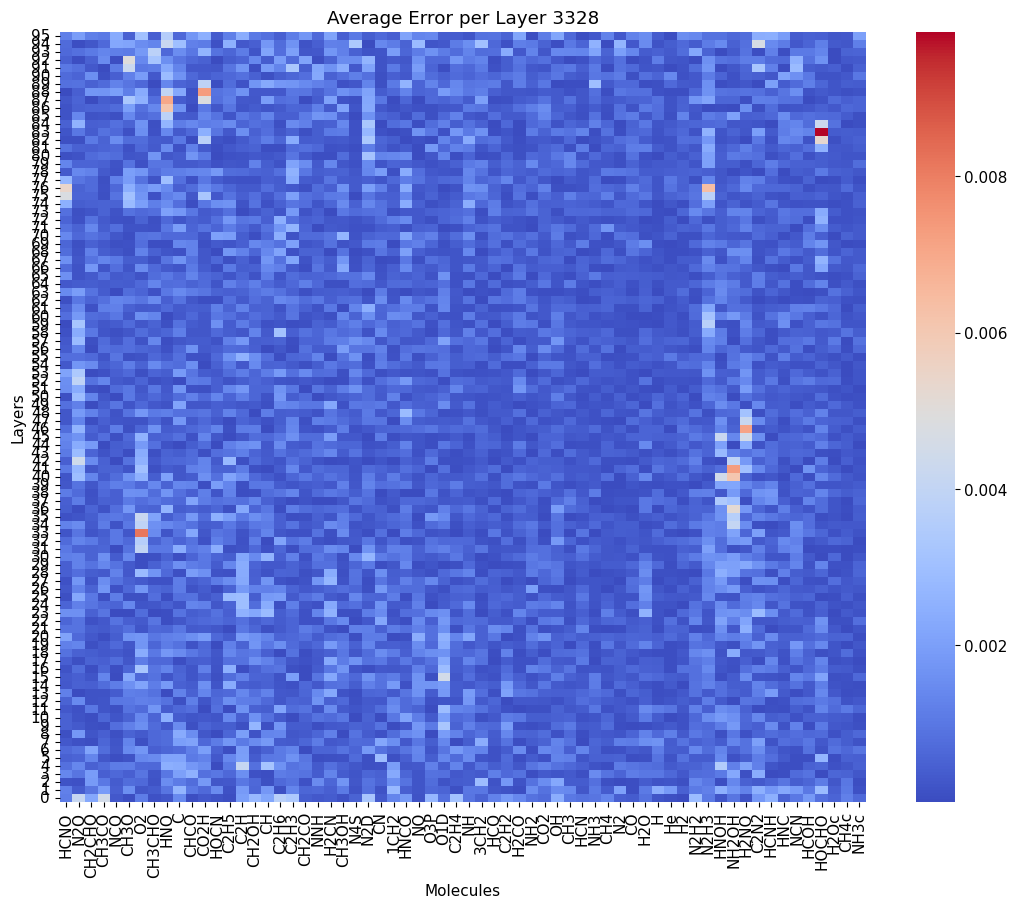

In [19]:
random_values = random.sample(range(0, 5149), 2)
for n in random_values:
    logVMR_vs_pressure(network_output, network_input, ground_truth, n, 
                   chosen_molecules, pressure, name='D', save=False)
    average_importance =np.abs(network_output[n] - ground_truth[n])
    plt.figure(figsize=(13, 10))
    sns.heatmap(average_importance.T, cmap='coolwarm', xticklabels=molecules, yticklabels=range(network_output.shape[2]))
    plt.title(f'Average Error per Layer {n}')
    plt.xlabel('Molecules')
    plt.ylabel('Layers')
    plt.gca().invert_yaxis()
    plt.xticks(rotation=90)
    plt.show()

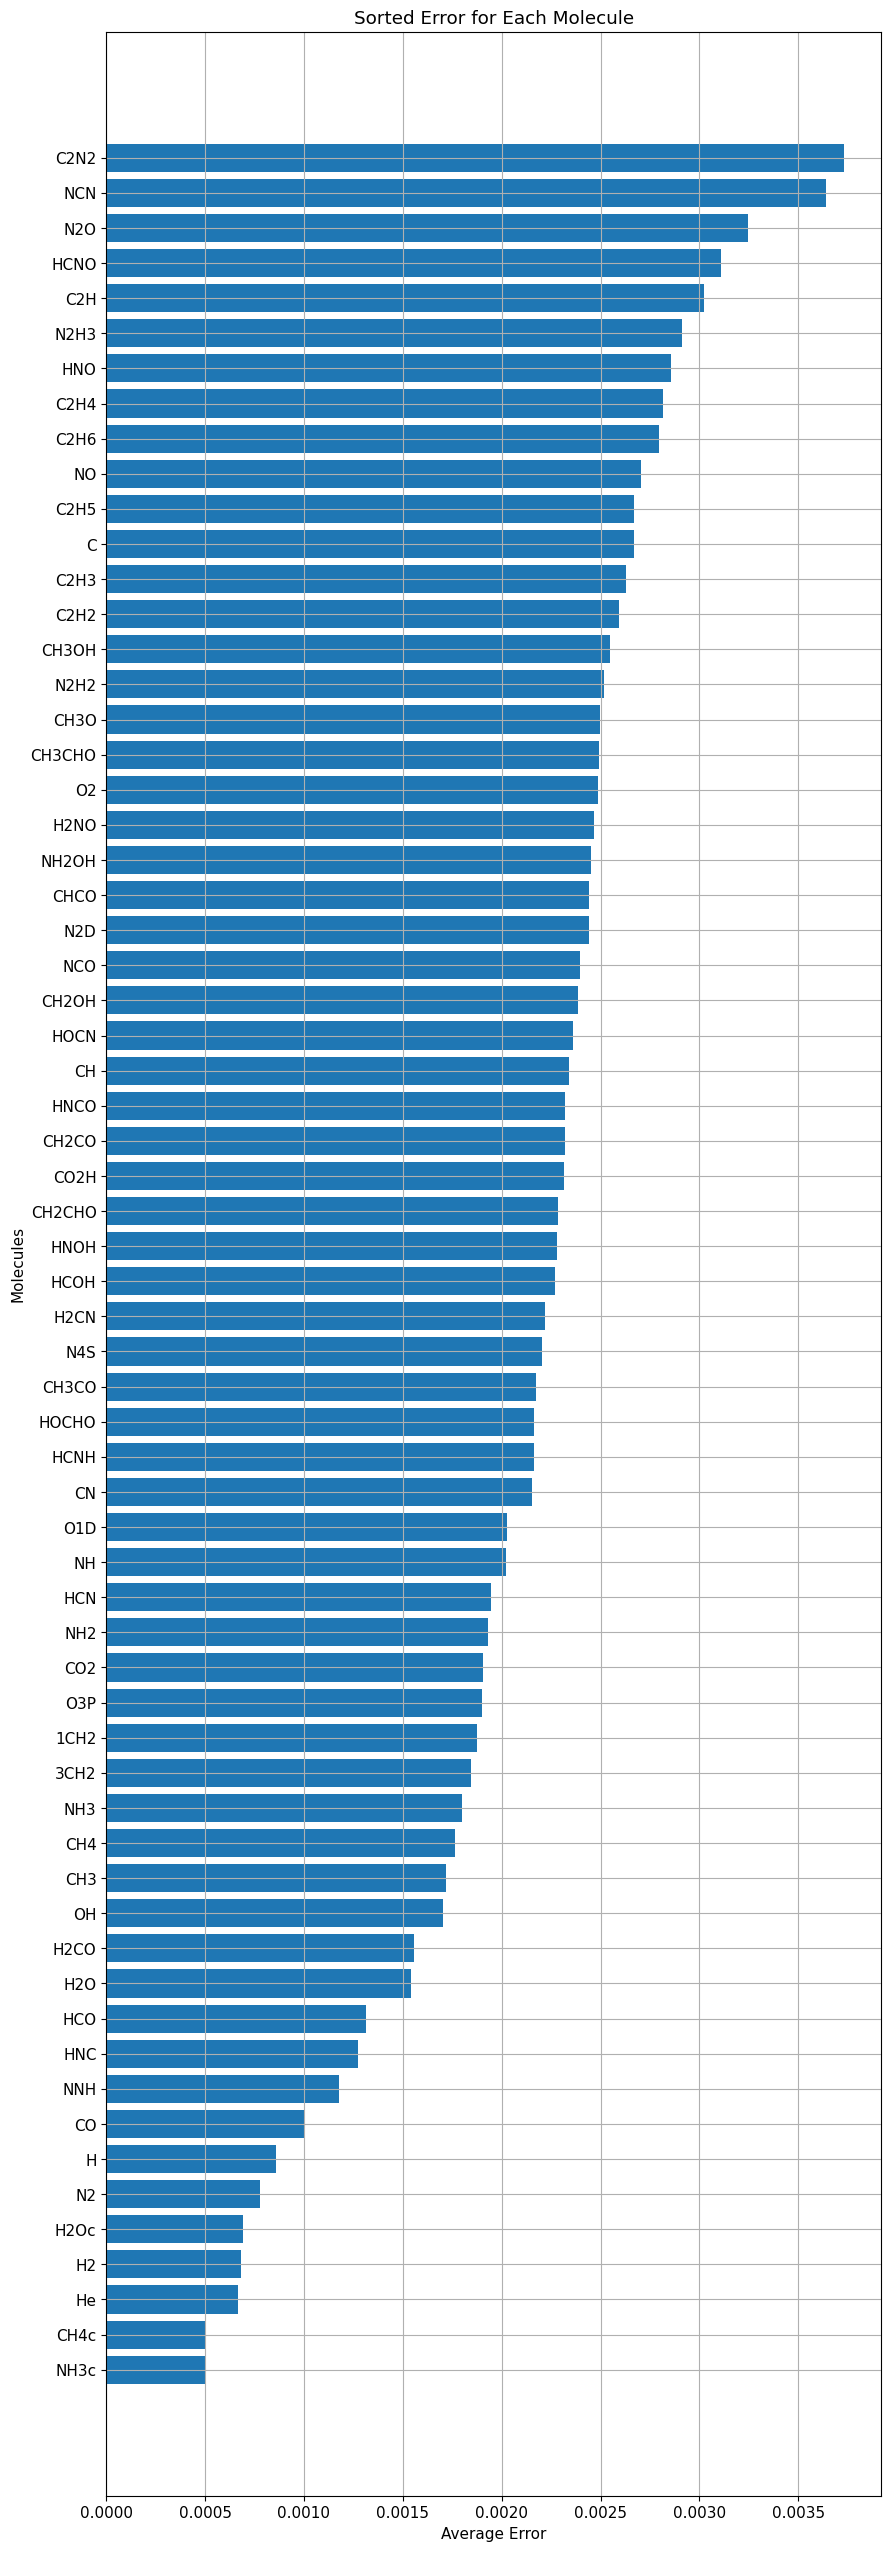

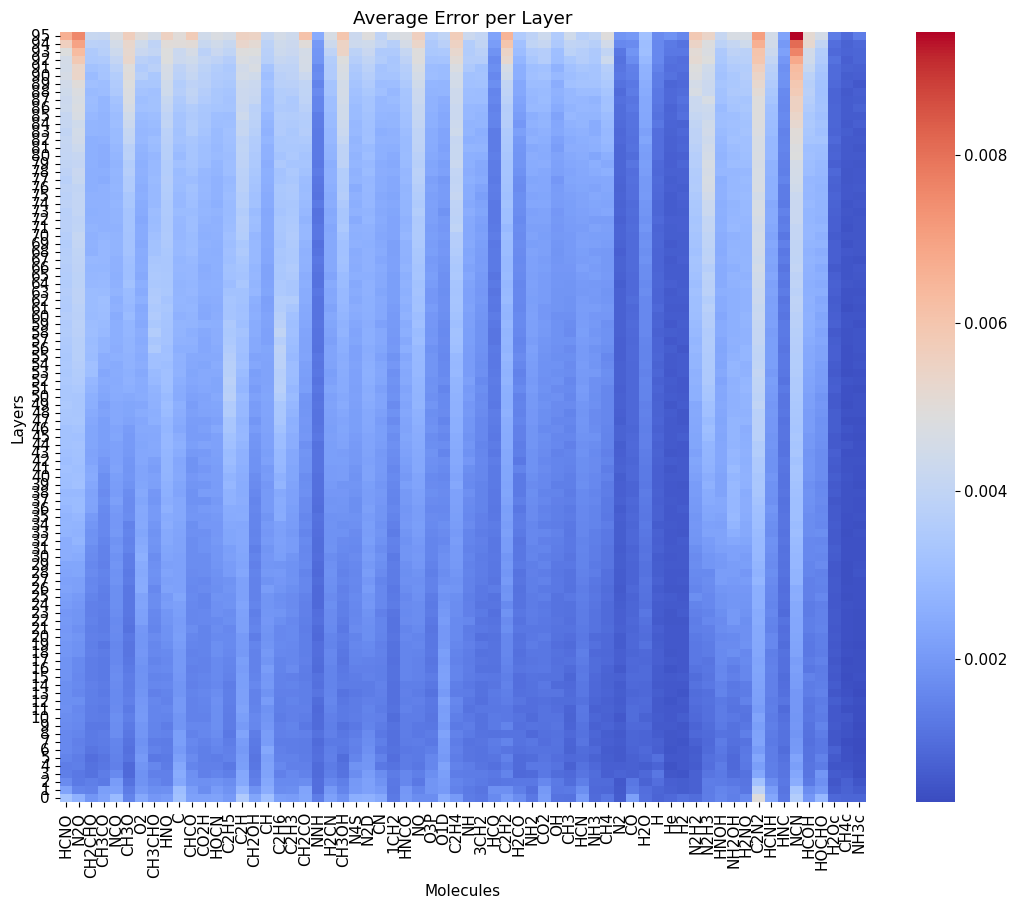

In [20]:
feature_importance = np.mean(np.abs(network_output - ground_truth), axis=0).mean(axis=1)
# Sort feature importance and corresponding molecules
sorted_indices = np.argsort(feature_importance)
sorted_importance = feature_importance[sorted_indices]
sorted_molecules = [molecules[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, len(sorted_molecules)/2))
plt.barh(sorted_molecules, sorted_importance)
plt.xlabel('Average Error')
plt.ylabel('Molecules')
plt.title('Sorted Error for Each Molecule')
plt.grid()
plt.show()



average_importance = np.mean(np.abs(network_output - ground_truth), axis=0)
plt.figure(figsize=(13, 10))
sns.heatmap(average_importance.T, cmap='coolwarm', xticklabels=molecules, yticklabels=range(network_output.shape[2]))
plt.title('Average Error per Layer')
plt.xlabel('Molecules')
plt.ylabel('Layers')
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.show()

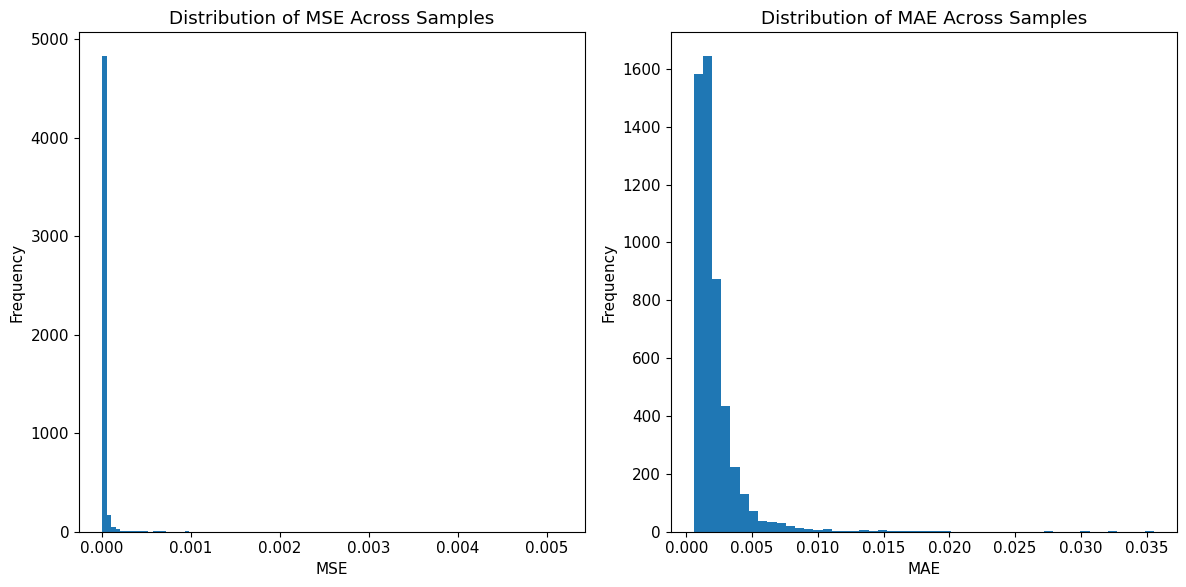

In [21]:
# 2. Consistency Across Samples
individual_mse = np.mean((ground_truth - network_output)**2, axis=(1, 2))
individual_mae = np.mean(np.abs(ground_truth - network_output), axis=(1, 2))
# Identifying high-error samples
high_error_threshold = np.percentile(individual_mae, 90)
high_error_indices = np.where(individual_mse > high_error_threshold)[0]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(individual_mse, bins=100)
plt.title('Distribution of MSE Across Samples')
plt.xlabel('MSE')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(individual_mae, bins=50)
plt.title('Distribution of MAE Across Samples')
plt.xlabel('MAE')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [27]:
def pair_plot(network_output, ground_truth, configuration, name, save=False):
    color = np.mean(np.abs(network_output - ground_truth), axis=(1, 2))
    norm = plt.Normalize(color.min(), color.max())
    cmap = plt.cm.Spectral_r
    # Define parameters for the plots (original parameter names)
    parameters = ['planet_mass', 'co_ratio', 'isothermal_T', 'metalicity']
    # Mapping to more descriptive axis labels
    label_map = {
        'planet_mass': 'Planet Mass [$M_J$]',
        'co_ratio': 'C/O Ratio',
        'isothermal_T': 'Temperature [K]',
        'metalicity': 'Metalicity'
    }
    n = len(parameters)
    
    # Create subplots
    fig, axs = plt.subplots(n, n, figsize=(5*n, 4*n), constrained_layout=True)
    for i, param_i in enumerate(parameters):
        for j, param_j in enumerate(parameters):
            if i > j:  # Fill only the lower triangle excluding the diagonal
                sc = axs[i, j].scatter(configuration[param_j], configuration[param_i], c=color,
                                       norm=norm, cmap=cmap)

                # Set labels only on the outer axes, using the descriptive names
                if i == n - 1:  # Bottom row
                    axs[i, j].set_xlabel(label_map[param_j], fontsize=15)
                if j == 0:  # Left-most column
                    axs[i, j].set_ylabel(label_map[param_i], fontsize=15)        
            else:
                fig.delaxes(axs[i][j])  # Remove unused subplots
    plt.tight_layout(pad=3.0)
    plt.suptitle(f'Model {name}: Distribution of Initial Exoplanet Parameters colored by MAE',
                 x=0.3, y=0.75, fontsize=15)
    fig.subplots_adjust(right=0.8)  # Make room for the colorbar
    cbar_ax = fig.add_axes([0.1,-0.02, 0.4, 0.02])  # Adjusted position
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')  # Correct orientation
    cbar_ax.yaxis.set_label_position("left")
    cbar_ax.set_title('Mean Absolute Error', pad=10, fontsize=11)
    if save:
        plt.savefig(f'initial_parameters_{name}_V2.png', dpi=1000, bbox_inches='tight')
    plt.show()

/var/folders/dl/nb0wq2jj5y9_03t1r0rpldc80000gn/T/ipykernel_14991/2796355031.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=3.0)


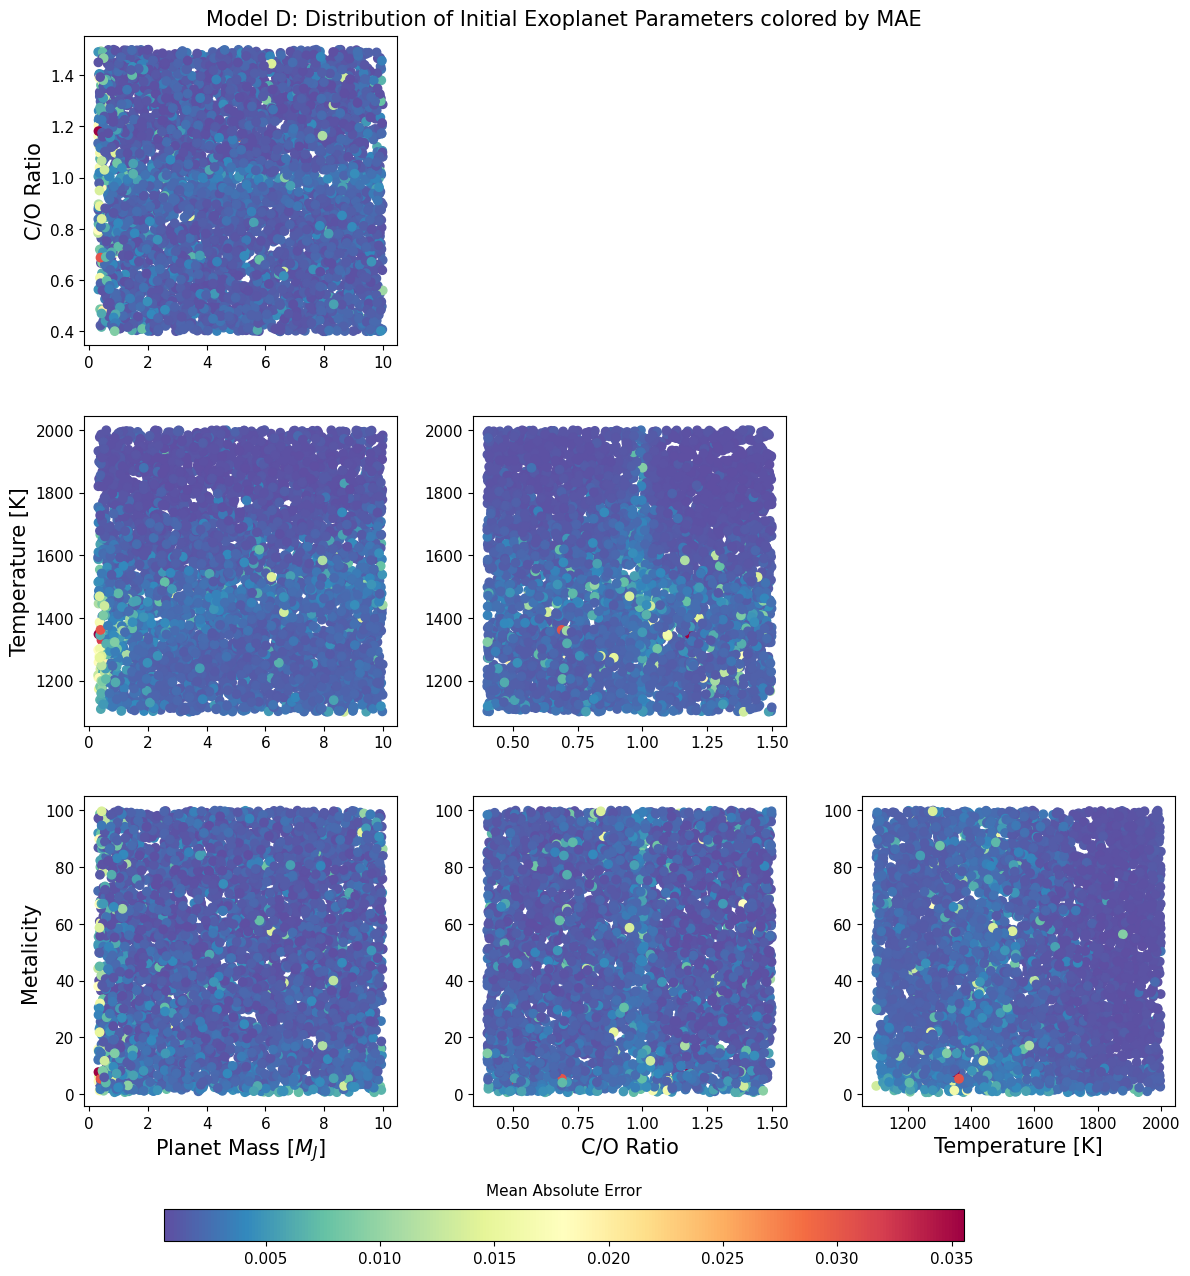

In [29]:
pair_plot(network_output,ground_truth, configuration, 'D', save = True)

In [31]:
def plot_mae_vs_temperature(network_output, ground_truth, configuration,name, save=False):
    fig, ax = plt.subplots(figsize=(8, 6))
    sample_mae = calculate_samplewise_mae(network_output, ground_truth)
    configuration['Error'] = sample_mae
    # Plot for planet mass
    scatter = ax.scatter(x=configuration['isothermal_T'], y=configuration['Error'],
                         c=configuration['planet_mass'], alpha=1, zorder=3, s=30, 
                         edgecolor='black', linewidth=0.2, cmap='Spectral_r')
    # Creating color bar for planet mass
    cbar = plt.colorbar(scatter)
    cbar.set_label('Planet Mass $M_J$')

    ax.set_xlabel('Isothermal Temperature [K]')
    ax.set_ylabel('Mean Absolute Error')
    ax.set_title(f'Model {name}', fontsize = 13)
    plt.grid(alpha=0.5, zorder=0)
    if save:
        plt.savefig(f'MAE_vs_Temperature_Mass_color_Model{name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    # Plot for C/O Ratio
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(x=configuration['isothermal_T'], y=configuration['Error'],
                         c=configuration['co_ratio'], alpha=1, zorder=3, s=30, 
                         edgecolor='black', linewidth=0.2, cmap='Spectral_r')
    # Creating color bar for C/O Ratio
    cbar = plt.colorbar(scatter)
    cbar.set_label('C/O Ratio')

    plt.grid(alpha=0.5, zorder=0)
    ax.set_xlabel('Isothermal Temperature [K]')
    ax.set_ylabel('Mean Absolute Error')
    ax.set_title(f'Model {name}', fontsize = 13)
    
    if save:
        plt.savefig(f'MAE_vs_Temperature_COratio_color_Model{name}.png', dpi=300, bbox_inches='tight')
    plt.show()

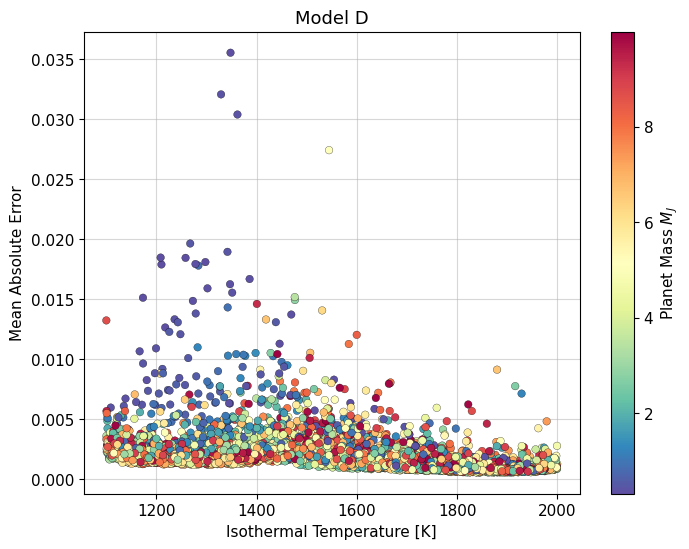

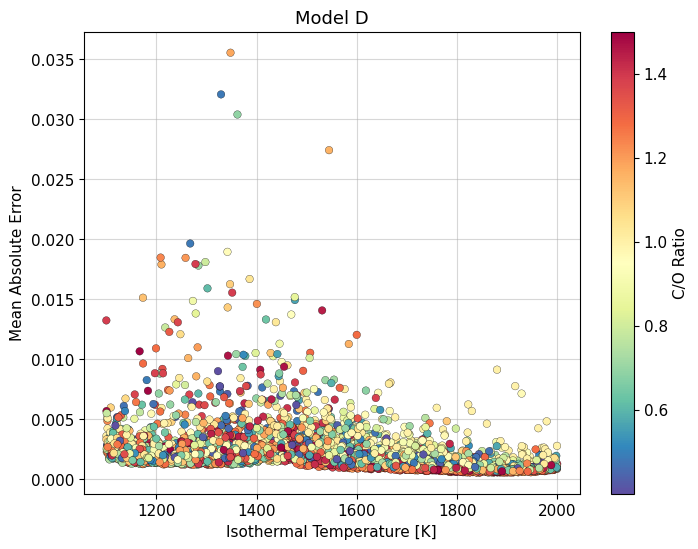

In [32]:
plot_mae_vs_temperature(network_output, ground_truth, configuration, 'D', save=True)

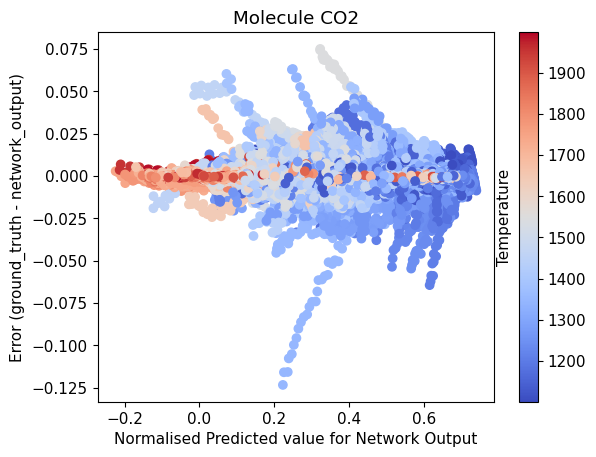

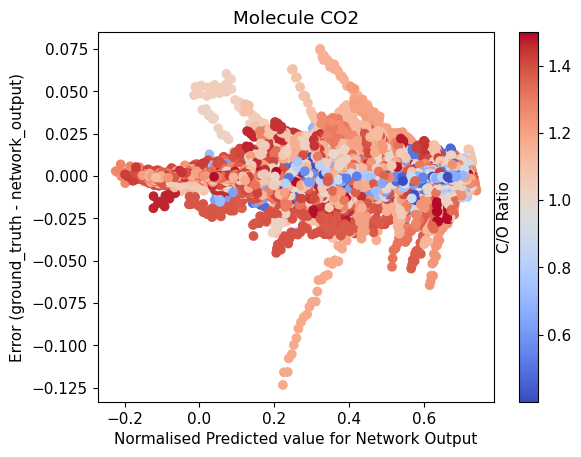

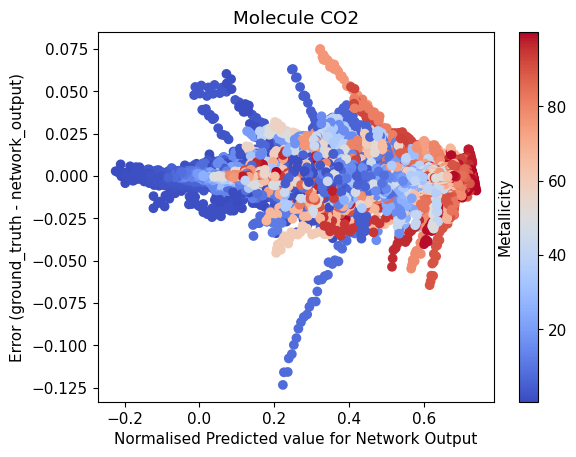

---------------------------------------- *Next Molecule* ----------------------------------------


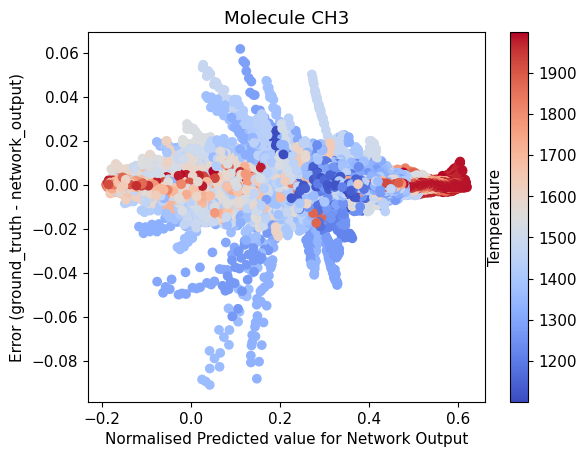

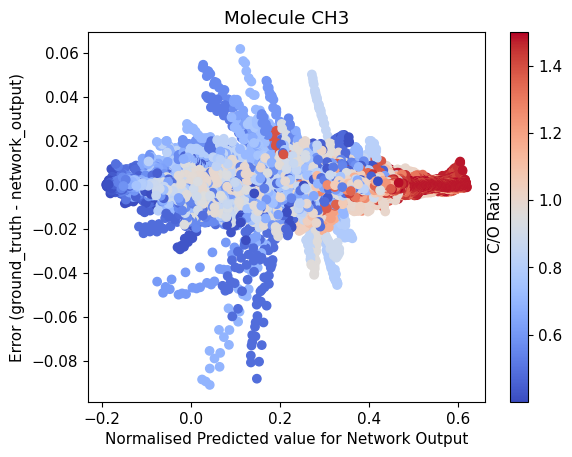

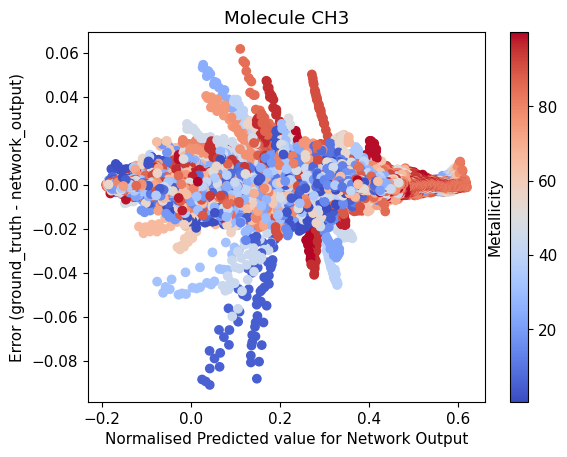

---------------------------------------- *Next Molecule* ----------------------------------------


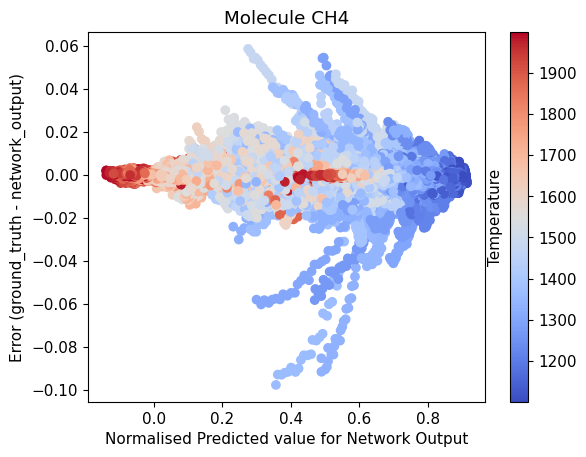

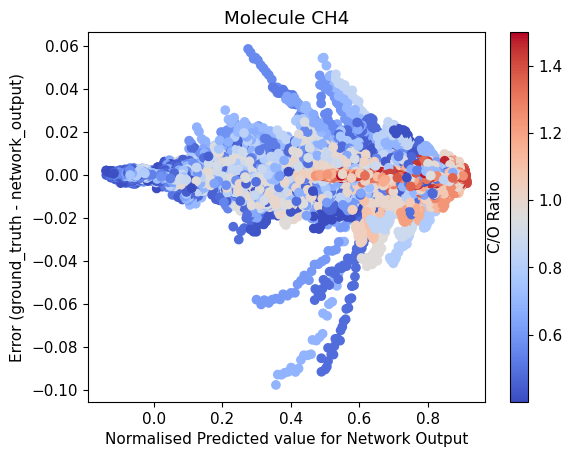

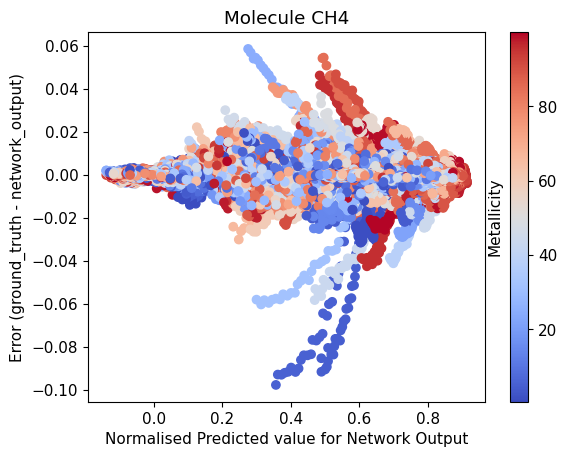

---------------------------------------- *Next Molecule* ----------------------------------------


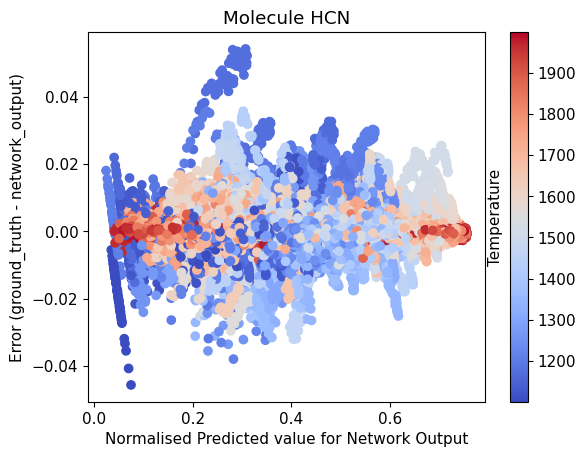

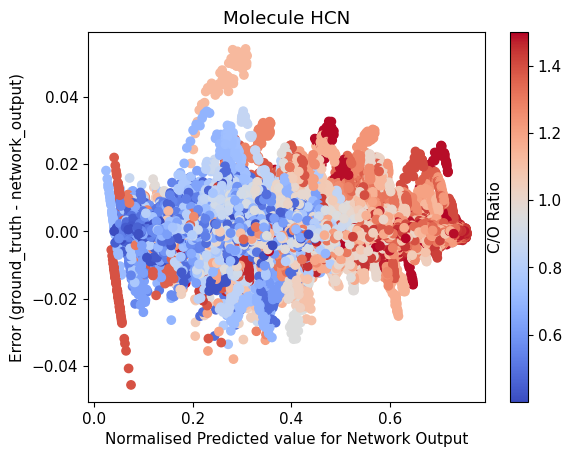

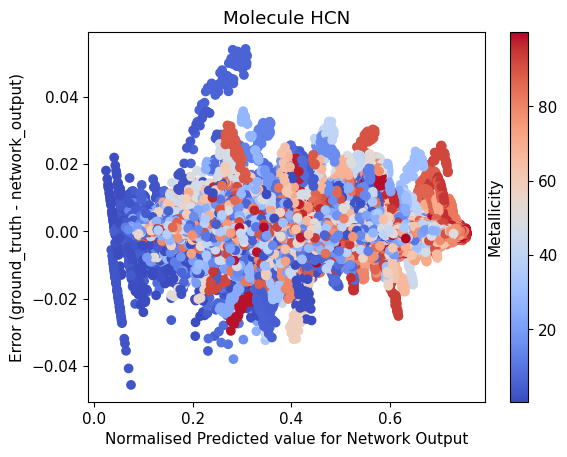

---------------------------------------- *Next Molecule* ----------------------------------------


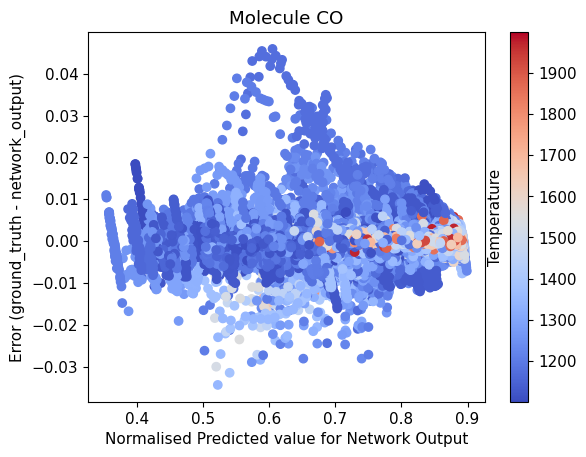

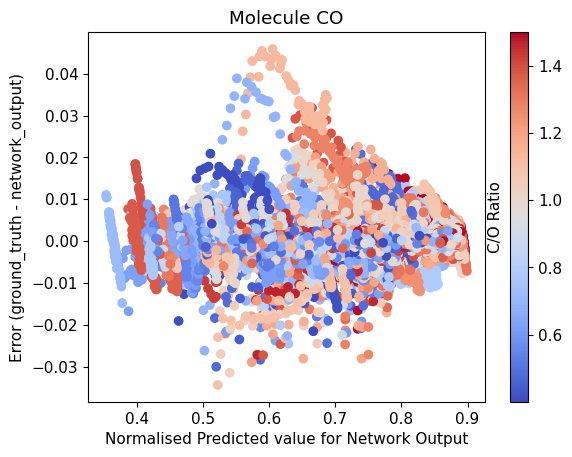

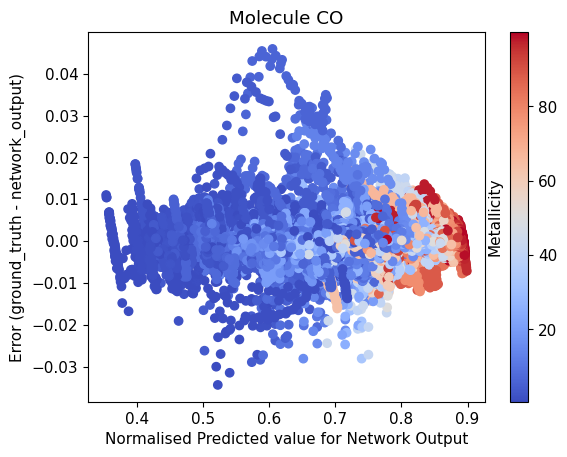

---------------------------------------- *Next Molecule* ----------------------------------------


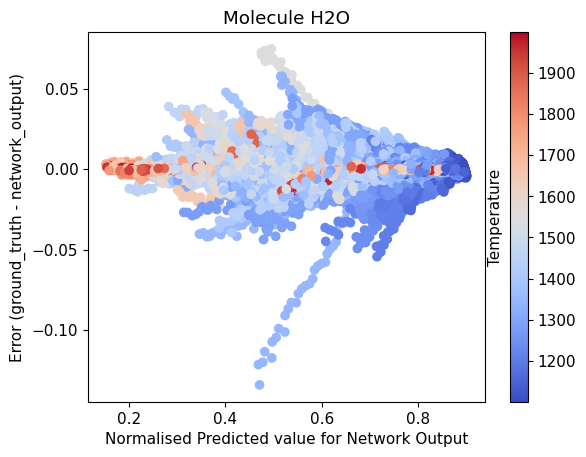

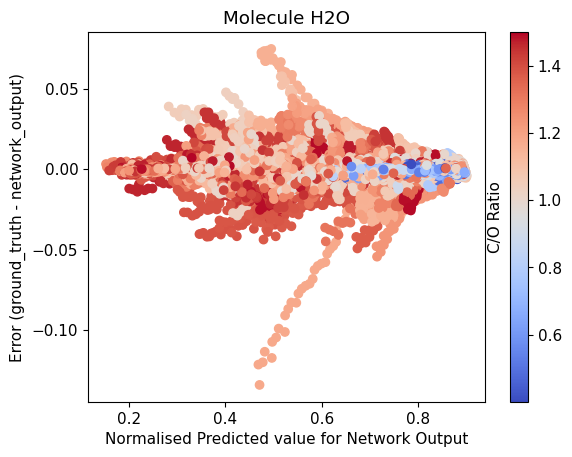

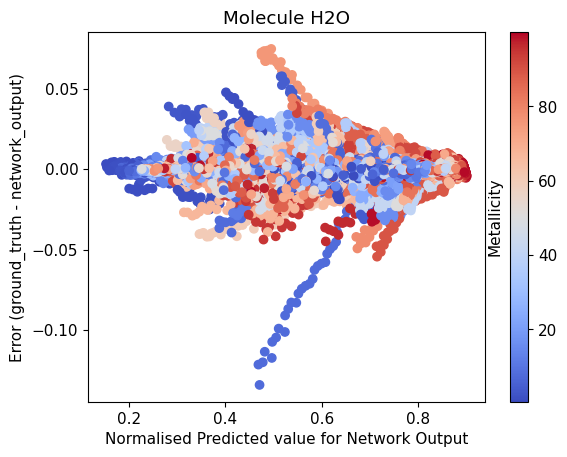

---------------------------------------- *Next Molecule* ----------------------------------------


In [22]:
all_ind = np.arange(0,len(ground_truth))
error = ground_truth - network_output
cmap = matplotlib.colormaps["coolwarm"]
norm = plt.Normalize(temp.min(), temp.max())
norm_co = plt.Normalize(co_ratio.min(), co_ratio.max())
norm_met = plt.Normalize(metallicity.min(), metallicity.max())
for ind in [38,40,43,41,45, 46]: #random.sample(range(0, 64), 5): # [38,40,43,41,45, 46]
    for layer in range(0, 64):
        plt.scatter(network_output[:,ind,layer].flatten(), error[:,ind,layer].flatten(),c = temp, cmap=cmap, norm=norm)
    cbar = plt.colorbar()
    cbar.set_label('Temperature', rotation=90, labelpad=5)
    cbar.ax.yaxis.set_label_position('left')
    plt.title(f'Molecule {molecules[ind]}')
    plt.xlabel('Normalised Predicted value for Network Output')
    plt.ylabel('Error (ground_truth - network_output)')
    plt.savefig(f'{molecules[ind]}_temp.png')
    plt.show()
    for layer in range(0, 64):
        plt.scatter(network_output[:,ind,layer].flatten(), error[:,ind,layer].flatten(),c = co_ratio, cmap=cmap, norm=norm_co)
    cbar = plt.colorbar()
    cbar.set_label('C/O Ratio', rotation=90, labelpad=5)
    cbar.ax.yaxis.set_label_position('left')
    plt.title(f'Molecule {molecules[ind]}')
    plt.xlabel('Normalised Predicted value for Network Output')
    plt.ylabel('Error (ground_truth - network_output)')
    plt.savefig(f'{molecules[ind]}_coratio.png')
    plt.show()
    for layer in range(64):
        plt.scatter(network_output[:,ind,layer].flatten(), error[:,ind,layer].flatten(),c = metallicity, cmap=cmap, norm=norm_met)
    cbar = plt.colorbar()
    cbar.set_label('Metallicity', rotation=90, labelpad=5)
    cbar.ax.yaxis.set_label_position('left')
    plt.title(f'Molecule {molecules[ind]}')
    plt.xlabel('Normalised Predicted value for Network Output')
    plt.ylabel('Error (ground_truth - network_output)')
    plt.savefig(f'{molecules[ind]}_metallicity.png')
    plt.show()
    print('--'*20, '*Next Molecule*','--'*20 )

In [ ]:
all_ind = np.arange(0,len(ground_truth))
error = ground_truth - network_output
cmap = matplotlib.colormaps["coolwarm"]
norm = plt.Normalize(temp.min(), temp.max())
for ind in range(0,64):
    for layer in range(64):
        plt.scatter(network_output[:,ind,layer].flatten(), error[:,ind,layer].flatten(),c = temp, cmap=cmap, norm=norm)
    cbar = plt.colorbar()
    cbar.set_label('Temperature', rotation=90, labelpad=5)
    cbar.ax.yaxis.set_label_position('left')
    plt.title(f'Molecule {molecules[ind]}')
    plt.xlabel('Normalised Predicted value for Network Output')
    plt.ylabel('Error (ground_truth - network_output)')
    plt.show()

In [23]:
def molecule_layer_error(input_data, gt,co_ratio, molecule, name=None):
    n_colors = 100  # You can adjust the number of colors for smoother or more discrete gradients
    cmap = mcolors.LinearSegmentedColormap.from_list("CustomCmap", ['#649DA5','#6FAEB7', '#F4EBAB','#E8A065'], N=n_colors)
    
    
    
    df_molecule = pd.DataFrame(input_data[:, molecules.index(molecule), :].T)
    gt_molecule = pd.DataFrame(gt[:, molecules.index(molecule), :].T)
    err = df_molecule-gt_molecule
    #hex_colors = ['#6FAEB7','#FED9BE','#F4EBAB','#E8A065']
    #custom_cmap = ListedColormap(hex_colors)

    cmap = plt.cm.get_cmap(cmap)
    norm = plt.Normalize(co_ratio.min(), co_ratio.max())

    # Define the scatter plot function
    def plot_scatter(var):
        # Clear the previous plot
        plt.clf()

        # Create scatter plot with color-coded markers based on co_ratio
        plt.scatter(np.array(df_molecule.iloc[var].to_list()), np.array(err.iloc[var].to_list()), c=co_ratio, cmap=cmap, norm=norm)

        # Add colorbar
        cbar = plt.colorbar()
        cbar.set_label(name)

        # Set the plot title and axis labels
        plt.title(f'Molecule {molecule} Layer: {var}')
        plt.xlabel('log(Volume Mixing Ratio)')
        plt.ylabel('MAE')

        # Show the plot
        plt.show()

    # Create the interactive plot using the interact function
    interact(plot_scatter, var=(0, 63, 1))
    plt.show()

In [15]:
error = ground_truth - network_output
molecule_layer_error(network_output, ground_truth,co_ratio, 'O2', name=None)

/var/folders/dl/nb0wq2jj5y9_03t1r0rpldc80000gn/T/ipykernel_23151/3345607594.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)


interactive(children=(IntSlider(value=31, description='var', max=63), Output()), _dom_classes=('widget-interac…

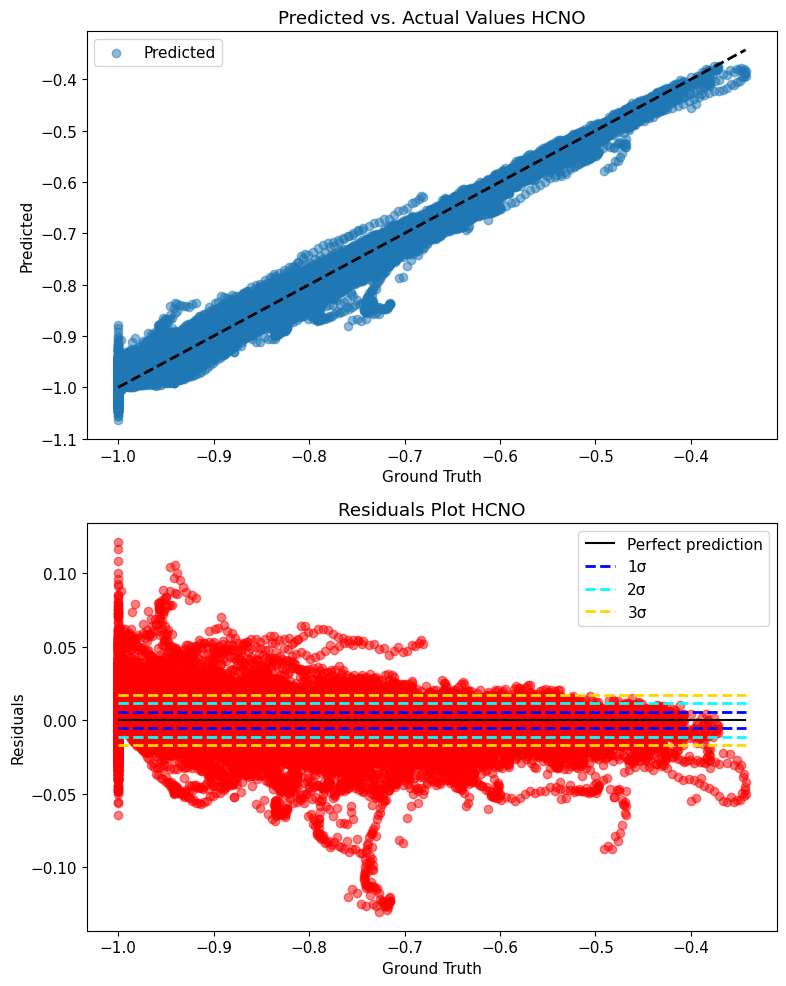

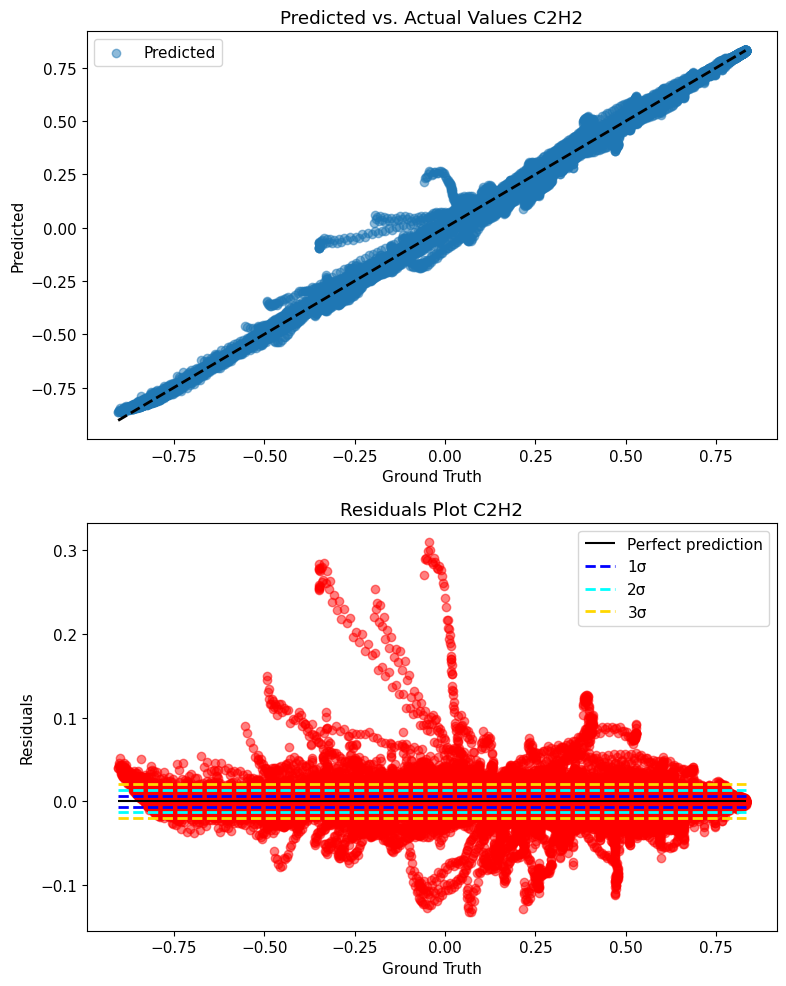

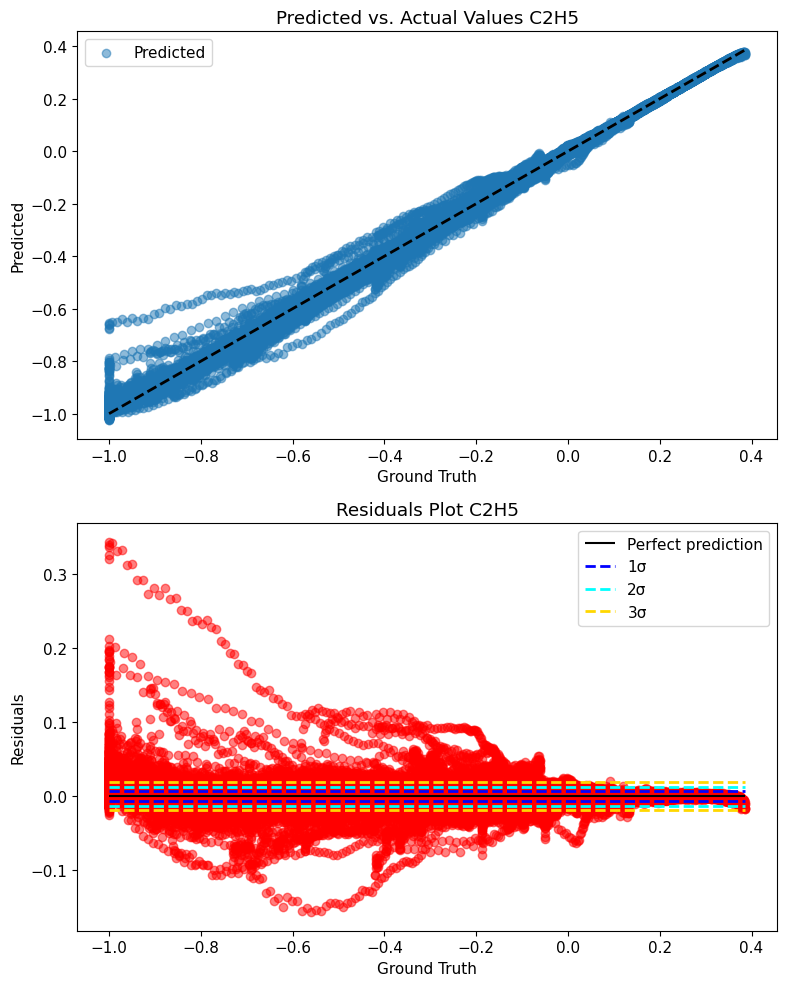

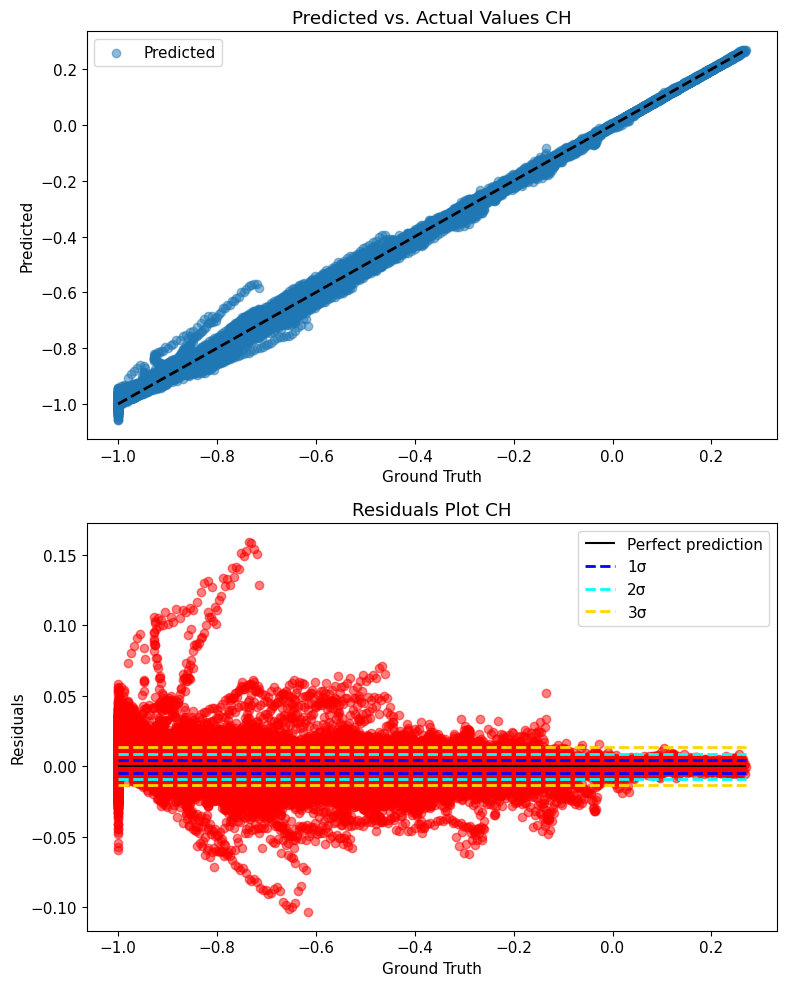

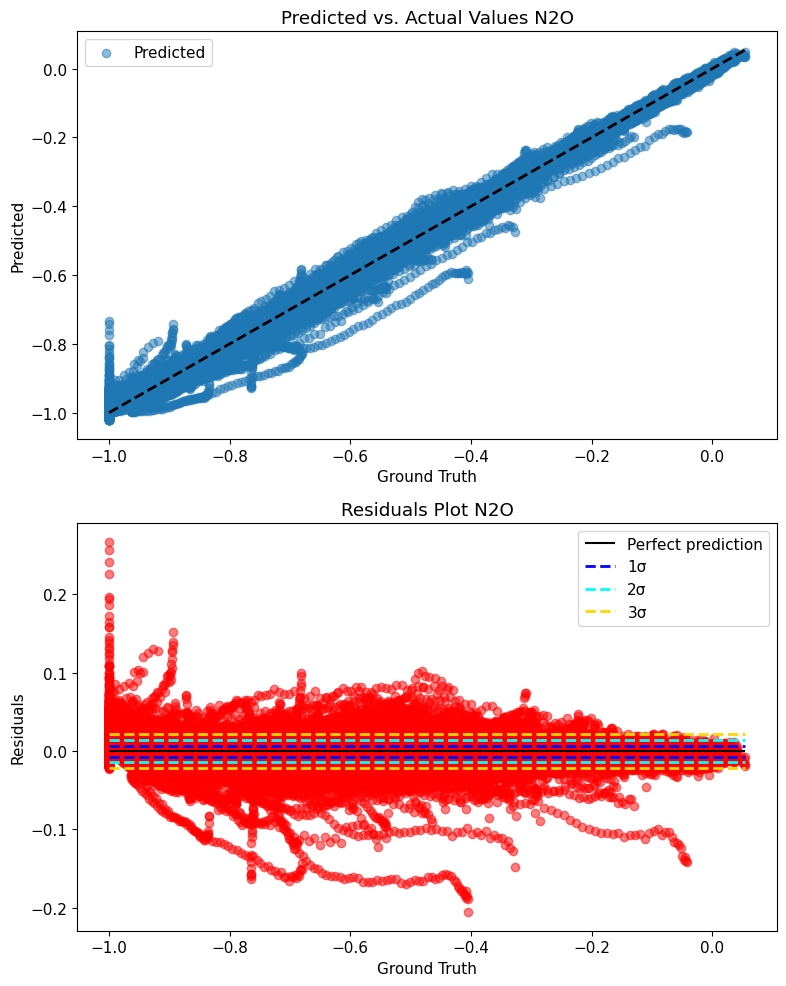

In [24]:
all_ind = np.arange(0,len(ground_truth))
for ind in random.sample(range(0, 64), 5):
    gt_vs_predict_plot(ground_truth,network_output,
                       network_input,all_ind,ind,input_data=False)


In [ ]:
#2489, 2006, 441
n=1318
for ind in random.sample(range(0, 64), 5): #range(0,64):
    gt_vs_predict_plot(ground_truth,network_output,network_input,n,ind)


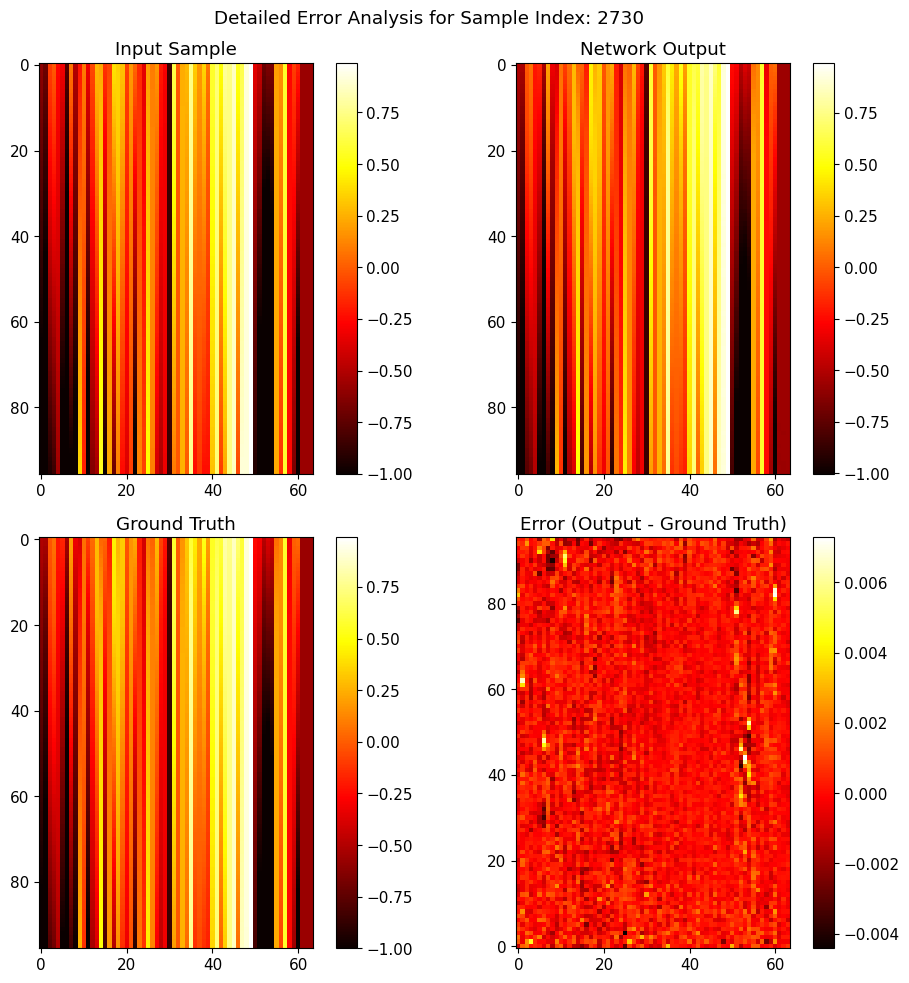

Error Statistics for Sample 2730:
Mean Error: 3.177242628653453e-05
Median Error: 1.016372114115427e-05
Standard Deviation of Error: 0.0007931326948246612


In [25]:
sample_idx = l_error
visualize_sample_analysis(network_input, network_output, ground_truth,sample_idx)

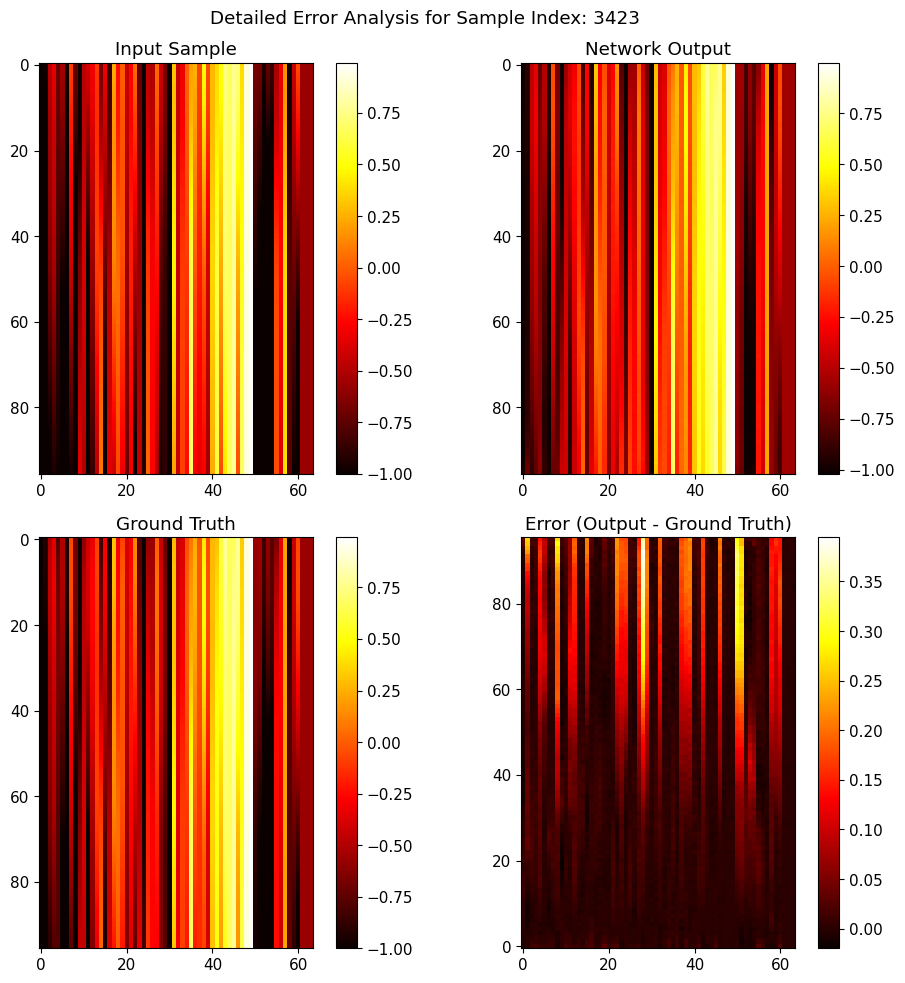

Error Statistics for Sample 3423:
Mean Error: 0.033905677468337996
Median Error: 0.004823189320981802
Standard Deviation of Error: 0.06342678374204606


In [26]:
sample_idx = h_error
visualize_sample_analysis(network_input, network_output, ground_truth,sample_idx)